<a href="https://colab.research.google.com/github/jeric250/Data-Science-Projects/blob/main/Genetic_Mutation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classify Genetic Mutation Based on Text Based Clinical Evidence
Once sequenced, a cancer tumor can have thousands of genetic mutations, and the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Typically this interpretation of genetic mutations is done manually. This is a very time consuming task where a clinical pathologist manually reviews and classifies every single genetic mutation based on evidence from text-based clinical literature.

Using a dataset sourced from [Kaggle](https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/overview), the goal is to build a ML algorithm that can automatically classify genetic variations. In this case, there are 9 different classes a genetic mutation can take. This is partly inspired by the course work from the Applied Roots's [Applied Machine Learning course](https://www.appliedaicourse.com/course/11/Applied-Machine-learning-course).

In this ML problem, errors can be very costly, and interpretability of model output is important. Thus, probability of a given data point belonging to each class is needed. To evaluate the predicted probabilites, log loss is used as the main performance metric. [Log loss](https://stats.stackexchange.com/questions/180116/when-is-log-loss-metric-appropriate-for-evaluating-performance-of-a-classifier) heavily penalises classifiers that are confident about an incorrect classification (e.g. assigning a small probablity to the correct class). 

The following ML algorithms are used in this case study: Naive Bayes, Logistic Regression, Random Forest, XGBoost. As the dataset comprises of text and categorical data, some exploratory data analysis is performed to better understand the data, alongisde text preprocessing and encoding. 

#### 1. Load Data

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss
from scipy.sparse import hstack

from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import re

import pickle
from tqdm import tqdm
import os

In [ ]:
!pip install xgboost --upgrade 
# latest version is still 1.3.1?
# update via Anaconda prompt instead: https://stackoverflow.com/questions/35139108/how-to-install-xgboost-in-anaconda-python-windows-platform

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\acer\\anaconda3\\lib\\site-packages\\~gboost\\lib\\xgboost.dll'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.3.1
    Uninstalling xgboost-1.3.1:
      Successfully uninstalled xgboost-1.3.1


In [ ]:
!pip install opendatasets

  Running setup.py bdist_wheel for kaggle: started
  Running setup.py bdist_wheel for kaggle: finished with status 'done'
  Stored in directory: C:\Users\acer\AppData\Local\pip\Cache\wheels\a1\6a\26\d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
cryptography 3.3.1 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.
You are using pip version 10.0.1, however version 22.2.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
# to download data from Kaggle
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/data") 
# must accept competition rules first, and data downloaded to same location as notebook when saved

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jericlam
Your Kaggle Key: ········


100%|█████████▉| 168M/169M [00:17<00:00, 9.23MB/s] 

100%|██████████| 169M/169M [00:17<00:00, 9.98MB/s]


Extracting archive .\msk-redefining-cancer-treatment/msk-redefining-cancer-treatment.zip to .\msk-redefining-cancer-treatment


In [ ]:
# read csv file (gene, variation) from zipped folder (prefer this version as neater)
# https://stackoverflow.com/questions/26942476/reading-csv-zipped-files-in-python
df_v = pd.read_csv('C:/Users/acer/msk-redefining-cancer-treatment/training_variants.zip',compression='zip')
df_v.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
df_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [ ]:
# read csv file (text) from zipped folder
# https://stackoverflow.com/questions/26942476/reading-csv-zipped-files-in-python
df_text = pd.read_csv('C:/Users/acer/msk-redefining-cancer-treatment/training_text.zip',compression='zip',sep="\|\|",
                 engine="python",names=["ID","TEXT"],skiprows=1,encoding='utf-8') # use encoding to address error (ref: https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data)
df_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [ ]:
# find rows where text col is null (without any(axis=1), all rows returned with NaN/True)
# https://stackoverflow.com/questions/14247586/how-to-select-rows-with-one-or-more-nulls-from-a-pandas-dataframe-without-listin
df_text[df_text.isnull().any(axis=1)]

,ID,TEXT
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


In [ ]:
df_text.iloc[22,1] # sample text col: index 22, col 1

'Oncogenic mutations in the monomeric Casitas B-lineage lymphoma (Cbl) gene have been found in many tumors, but their significance remains largely unknown. Several human c-Cbl (CBL) structures have recently been solved depicting the protein at different stages of its activation cycle and thus provide mechanistic insight underlying how stability-activity tradeoffs in cancer-related proteins may influence disease onset and progression. In this study, we computationally modeled the effects of missense cancer mutations on structures representing four stages of the CBL activation cycle to identify driver mutations that affect CBL stability, binding, and activity. We found that recurrent, homozygous, and leukemia-specific mutations had greater destabilizing effects on CBL states than did random non-cancer mutations. We further tested the ability of these computational models assessing the changes in CBL stability and its binding to ubiquitin conjugating enzyme E2, by performing blind CBL-med

#### 2. Preprocess Text

In [ ]:
# load stop words from nltk library
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# define text preprocessing function to remove special char and change words to lower case
def text_preprocessing(df, index, text_column):
    text = df[text_column][index]
    if type(text) is str:
        string = ""
        # replace every special char with space (exclude "a-z","A-Z", 0-9 and "\n")
        # \n is excluded as if \n is replaced with space, there will be no newline
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # replace multiple spaces (and single space) with single space
        text = re.sub('\s+',' ', text)
        # converting all chars into lower-case
        text = text.lower()
        
        # for each word in text, if a word is a not stop word then retain that word
        for word in text.split():
            if not word in stop_words:
                string += word + " "
        
        df[text_column][index] = string
    else:
        print("There is no text for id:",index)

In [ ]:
# run text preprocessing
for index, row in tqdm(df_text.iterrows()):
    text_preprocessing(df_text, index, 'TEXT')

1119it [00:11, 101.20it/s]

There is no text for id: 1109


1283it [00:13, 104.49it/s]

There is no text for id: 1277


1424it [00:14, 119.95it/s]

There is no text for id: 1407


1656it [00:17, 95.66it/s] 

There is no text for id: 1639


2764it [00:29, 80.65it/s] 

There is no text for id: 2755


3321it [00:35, 93.71it/s] 


In [ ]:
df_text.iloc[22,1] # sample text col after preprocessing

'oncogenic mutations monomeric casitas b lineage lymphoma cbl gene found many tumors significance remains largely unknown several human c cbl cbl structures recently solved depicting protein different stages activation cycle thus provide mechanistic insight underlying stability activity tradeoffs cancer related proteins may influence disease onset progression study computationally modeled effects missense cancer mutations structures representing four stages cbl activation cycle identify driver mutations affect cbl stability binding activity found recurrent homozygous leukemia specific mutations greater destabilizing effects cbl states random non cancer mutations tested ability computational models assessing changes cbl stability binding ubiquitin conjugating enzyme e2 performing blind cbl mediated egfr ubiquitination assays cells experimental cbl ubiquitin ligase activity agreement predicted changes cbl stability lesser extent cbl e2 binding affinity two thirds experimentally tested mu

In [ ]:
# count the no. of rows with space (or multiple space) in gene col
counter = 0
for row in df_v['Gene']:
    if re.search('\s+', row):
        counter += 1
counter

0

In [ ]:
# replace space with _ for OHE as it will be done using CountVectorizer, which splits on space
df_v.Gene      = df_v.Gene.str.replace('\s+', '_')
df_v.Variation = df_v.Variation.str.replace('\s+', '_')

#### 3. Merge Gene, Variation, Text Data

In [ ]:
df = pd.merge(df_v, df_text, on='ID', how='left')
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   TEXT       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [ ]:
df[df.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating_Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [ ]:
# drop rows containing null text values as only 5 records will be dropped
# https://stackoverflow.com/questions/36370839/better-way-to-drop-nan-rows-in-pandas
df = df.dropna(subset=['TEXT']) # drop rows containing nan only from selected col
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3316 non-null   int64 
 1   Gene       3316 non-null   object
 2   Variation  3316 non-null   object
 3   Class      3316 non-null   int64 
 4   TEXT       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.4+ KB


#### 4. Perform EDA

In [ ]:
# obtain % breakdown of data pts by Class
class_p = df['Class'].value_counts(normalize=True).mul(100).round(2).reset_index()
class_p # index refers to Class, Class refers to % value

,index,Class
0,7,28.71
1,4,20.69
2,1,17.07
3,2,13.63
4,6,8.23
5,5,7.30
6,3,2.68
7,9,1.12
8,8,0.57


In [ ]:
# obtain count breakdown of data pts by Class
class_c = df['Class'].value_counts().sort_index().values
class_c

array([566, 452,  89, 686, 242, 273, 952,  19,  37], dtype=int64)

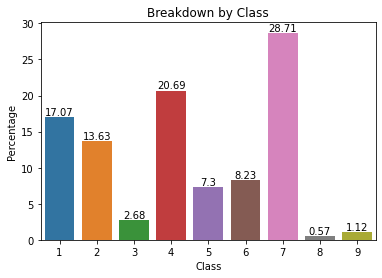

No. of data points for class 1 : 566
No. of data points for class 2 : 452
No. of data points for class 3 : 89
No. of data points for class 4 : 686
No. of data points for class 5 : 242
No. of data points for class 6 : 273
No. of data points for class 7 : 952
No. of data points for class 8 : 19
No. of data points for class 9 : 37


In [ ]:
ax = sns.barplot(x='index', y='Class', data=class_p)
ax.bar_label(ax.containers[0]) # get labels (https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
plt.ylabel('Percentage')
plt.xlabel('Class')
plt.title('Breakdown by Class')
plt.show(); # use ; to exclude text

for index, value in enumerate(class_c): # use enumerate (instead of iterrows) for array, list
    print("No. of data points for class {} : {}".format(index+1,value)) # +1 because index starts at 0 while Class starts at 1

>This dataset has imbalanced distribution of classes, where class 3, 8 and 9 are very infrequent. 

In [ ]:
# analyse gene feature
gene_unique = df['Gene'].value_counts()
print('No. of unique genes:', gene_unique.shape[0]) # shape[0] obtains no. of rows
gene_unique

No. of unique genes: 262


BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RICTOR      1
PIK3R3      1
PPM1D       1
WHSC1       1
FAM58A      1
Name: Gene, Length: 262, dtype: int64

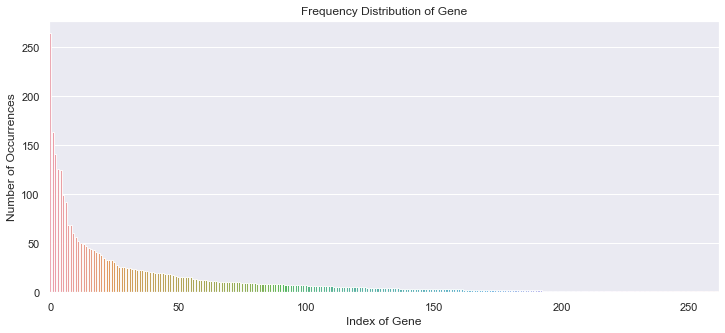

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,5))
sns.set(style="darkgrid")

# gene_unique.index returns index (gene name in this case), gene_unique.values returns counts for each gene
ax = sns.barplot(gene_unique.reset_index().index, gene_unique.values, alpha=0.9) # gene_unique.reset_index() allows index no. to be used
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # https://stackoverflow.com/questions/43639096/setting-the-interval-of-x-axis-for-seaborn-plot
plt.title('Frequency Distribution of Gene')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Index of Gene', fontsize=12)
plt.show()

> There are 262 unique values for the gene feature. Majority of gene values do not occur very frequently.

In [ ]:
# analyse variation feature
var_unique = df['Variation'].value_counts()
print('No. of unique variations:', var_unique.shape[0]) # shape[0] obtains no. of rows
var_unique

No. of unique variations: 2993


Truncating Mutations    92
Deletion                74
Amplification           70
Fusions                 34
Overexpression           6
                        ..
H1094R                   1
M1250T                   1
PTPRZ1-MET Fusion        1
H1106D                   1
K83E                     1
Name: Variation, Length: 2993, dtype: int64

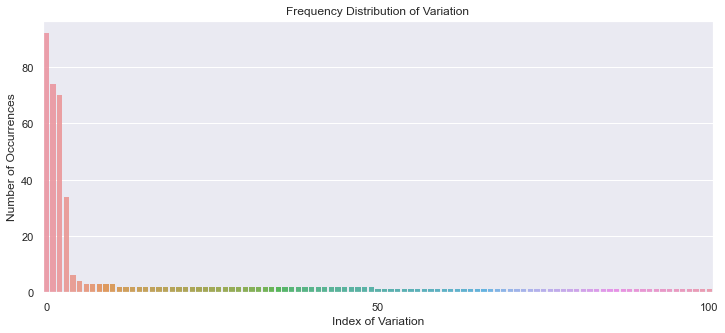

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,5))
sns.set(style="darkgrid")

# var_unique.index returns index, var_unique.values returns counts for each gene (limit to first 100 as barplot is wonky when show all)
ax = sns.barplot(var_unique.reset_index().index[:101], var_unique.values[:101], alpha=0.9, lw=0.) # gene_unique.reset_index() allows index no. to be used, lw=0 don't draw edges
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # https://stackoverflow.com/questions/43639096/setting-the-interval-of-x-axis-for-seaborn-plot
plt.title('Frequency Distribution of Variation')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Index of Variation', fontsize=12)
plt.show()

> There are 2993 unique values for the variation feature. Majority of variation values do not occur very frequently. Compared to gene feature, the variation feature is more skewed.

In [ ]:
# analyse text feature
# build a CountVectorizer with all the words that occured min 5 times
text_vec_eda = CountVectorizer(min_df=5)
text_vec_eda_ohe = text_vec_eda.fit_transform(df['TEXT'])

# obtain all feature names (words)
text_words = text_vec_eda.get_feature_names() # no difference vs get_feature_names_out()?

# obtain array of containing no. of occ for each word
# sum(axis=0): sum each row and A1 = ravel(): flatten matrix to shape (1, N) where N is no. of elements
word_count = text_vec_eda_ohe.sum(axis=0).A1 # output is shape (1, no. of feature/word): [3860, 8799, ...]

# zip(list(text_words), word_count) returns (word, no. of occ)
word_dict = dict(zip(list(text_words), word_count))

print("Total no. of unique words in Text of full dataset :", len(text_words))

Total no. of unique words in Text of full dataset : 48695


In [ ]:
# obtain list of words with their frequency
# sort dict by value (DESC) - https://stackoverflow.com/a/2258273/4084039
word_dict_sorted = dict(sorted(word_dict.items(), key=lambda x: x[1] , reverse=True))
word_dict_sorted

{'mutations': 238168,
 'cells': 185832,
 'cell': 126657,
 'mutation': 105671,
 'et': 104597,
 'fig': 104569,
 'al': 104412,
 'cancer': 99162,
 'figure': 98445,
 'patients': 86447,
 'protein': 84720,
 'expression': 77652,
 'activity': 76677,
 'mutant': 73387,
 'type': 72468,
 'tumor': 69514,
 'also': 66358,
 'variants': 66177,
 'kinase': 65798,
 'domain': 65388,
 'using': 63497,
 'binding': 62832,
 'gene': 61393,
 'brca1': 61344,
 'data': 60266,
 'analysis': 58962,
 'wild': 56951,
 'dna': 56315,
 '10': 56195,
 'egfr': 54761,
 'tumors': 53256,
 'mutants': 53190,
 'two': 52285,
 'table': 51861,
 'activation': 50169,
 'may': 49437,
 'results': 45962,
 'shown': 43895,
 'ras': 42558,
 'genes': 40875,
 'one': 40728,
 'p53': 40685,
 'proteins': 40639,
 'associated': 40497,
 'exon': 39154,
 'used': 38627,
 'human': 38504,
 'identified': 38268,
 'growth': 38042,
 'found': 37643,
 'kit': 37589,
 'function': 37375,
 'study': 36931,
 'signaling': 34970,
 'clinical': 34937,
 'levels': 34264,
 '20': 

In [ ]:
# obtain array of dict values (no. of occ)
word_array_sorted = np.array(list(word_dict_sorted.values()))
word_array_sorted

array([238168, 185832, 126657, ...,      5,      5,      5], dtype=int64)

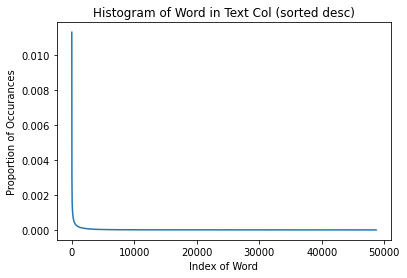

In [ ]:
proportion = word_array_sorted / sum(word_array_sorted)

plt.plot(proportion)
plt.xlabel('Index of Word')
plt.ylabel('Proportion of Occurances')
plt.title('Histogram of Word in Text Col (sorted desc)')
plt.show();

> There are 48,695 unique words that occured at least 5 times for the text feature. Majority of these words do not occur very frequently.

#### 5. Split Data into Train, Test Sets

In [ ]:
y = df['Class']
X = df.drop(['Class','ID'], axis=1)
X.head()

,Gene,Variation,TEXT
0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...
1,CBL,W802*,abstract background non small cell lung cancer...
2,CBL,Q249E,abstract background non small cell lung cancer...
3,CBL,N454D,recent evidence demonstrated acquired uniparen...
4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...


In [ ]:
# train test split (no validation set as intend to do Randomized Search CV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2652, 3) (2652,)
(664, 3) (664,)


#### 6. Perform Text Vectorization, Categorical Encoding

In [ ]:
# perform TF-IDF vectorization of text data (text column)
tfidf_vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=6000)
tfidf_vectorizer.fit(X_train['TEXT'].values) # fit only on train data

# use the fitted TfidfVectorizer to convert the text to vector
X_train_text_tfidf = tfidf_vectorizer.transform(X_train['TEXT'].values)
X_test_text_tfidf = tfidf_vectorizer.transform(X_test['TEXT'].values)

print(X_train_text_tfidf.shape, y_train.shape)
print(X_test_text_tfidf.shape, y_test.shape)

(2652, 6000) (2652,)
(664, 6000) (664,)


In [ ]:
# identify categorical features for encoding
categorical_col = list(X.select_dtypes(include=['object','category']).drop(['TEXT'], axis=1).columns)
categorical_col

['Gene', 'Variation']

>* Implementing one hot encoding on high cardinality categorical features will signficantly increase the dimensionality of training data. This in turn especially affects the performance of tree based models, since there is a need to evaluate each feature for information gain.
>* To address this, target encoding is used, where each category in a feature is replaced with the mean target value for samples having that category, while keeping the dimensionality of data the same as the unencoded data. As target encoding is prone to target leakage and overfitting, a stronger smoothing is used as a form of regularization. In essence, rare categories get less weight on their category average, while missing categories get the overall average.
>* As one hot encoding creates a high dimension space, linear models may work well as it may be easier for a hyperplane that seperate the classes to be found. However, in very high dimensional spaces, there is more than one plane that can be fitted to the data, and thus the model can perform poorly due to overfitting without proper regularization.
>* Thus, for tree based models like Random Forest and XGBoost, target encoded features will be used. For other models like logistic regression and Naive Bayes, one hot encoded features will be used.

In [ ]:
# use target encoder to encode categorical features
# https://www.kaggle.com/code/ryanholbrook/target-encoding
from category_encoders import TargetEncoder
enc_te = TargetEncoder(smoothing = 2.5) # use stronger smoothing than default
enc_te.fit(X_train[categorical_col], y_train) # fit on training data

# use the fitted encoder to encode categorical features
X_train_te = enc_te.transform(X_train[categorical_col])
X_test_te = enc_te.transform(X_test[categorical_col])

# use the fitted encoder to encode categorical features of train and test data
print(X_train_te.shape, y_train.shape)
print(X_test_te.shape, y_test.shape)

(2652, 2) (2652,)
(664, 2) (664,)


In [ ]:
# merge matrices for TF-IDF and target encoder
X_train_tfidf_te = hstack((X_train_text_tfidf, X_train_te)).tocsr()
X_test_tfidf_te = hstack((X_test_text_tfidf, X_test_te)).tocsr()

print("Final data matrix (TF-IDF & TE)")
print(X_train_tfidf_te.shape, y_train.shape)
print(X_test_tfidf_te.shape, y_test.shape)

Final data matrix (TF-IDF & TE)
(2652, 6002) (2652,)
(664, 6002) (664,)


In [ ]:
# use one hot encoder (CountVectorizer()) to encode categorical features
gene_vectorizer = CountVectorizer()
gene_vectorizer.fit(X_train['Gene'])

X_train_gene_ohe = gene_vectorizer.transform(X_train['Gene'])
X_test_gene_ohe = gene_vectorizer.transform(X_test['Gene'])

var_vectorizer = CountVectorizer()
var_vectorizer.fit(X_train['Variation'])

X_train_var_ohe = var_vectorizer.transform(X_train['Variation'])
X_test_var_ohe = var_vectorizer.transform(X_test['Variation'])

print(X_train_gene_ohe.shape, X_train_var_ohe.shape) # gene: 241 values, var: 2435 values
print(X_test_gene_ohe.shape, X_test_var_ohe.shape)

(2652, 241) (2652, 2435)
(664, 241) (664, 2435)


In [ ]:
# merge matrices for TF-IDF and OHE
X_train_tfidf_ohe = hstack((X_train_gene_ohe, X_train_var_ohe, X_train_text_tfidf)).tocsr()
X_test_tfidf_ohe = hstack((X_test_gene_ohe, X_test_var_ohe, X_test_text_tfidf)).tocsr()

print("Final data matrix (TF-IDF & OHE)")
print(X_train_tfidf_ohe.shape, y_train.shape)
print(X_test_tfidf_ohe.shape, y_test.shape)

Final data matrix (TF-IDF & OHE)
(2652, 8676) (2652,)
(664, 8676) (664,)


#### Addenum to EDA: Visalize with t-SNE

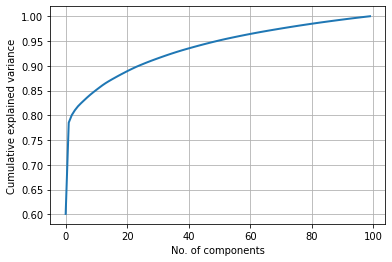

In [ ]:
# as t-SNE is computationally expensive, use PCA to reduce dim before using t-SNE
# https://www.kaggle.com/code/parulpandey/visualizing-kannada-mnist-with-t-sne/notebook
# https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
x_pca = pca.fit_transform(X_train_tfidf_te.todense())

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
# plt.figure(1, figsize=(6, 4))

plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('No. of components')
plt.ylabel('Cumulative explained variance')
plt.show()
# 20 components explain close to 90% of variance

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1500)
# perplexity: no. of nearest neighbours that are used, i.e. balance attention between local and global aspects of data (default: 30)
# n_iter: max no. of iter for optimization (default: 1000)
x_transformed = model.fit_transform(x_pca)

In [ ]:
print(x_transformed.shape)
print(y_train.shape)
tsne_data = np.column_stack((x_transformed, y_train))
print(tsne_data.shape)

(2652, 2)
(2652,)
(2652, 3)


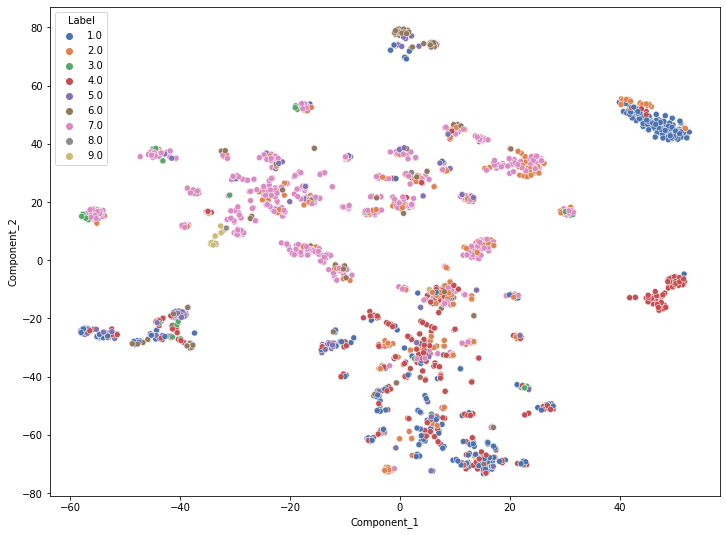

In [ ]:
tsne_data = np.column_stack((x_transformed, y_train))
tsne_df = pd.DataFrame(data=tsne_data, columns=("Component_1", "Component_2", "Label"))
# tsne_df['Label'] = tsne_df['Label'].astype(object)

plt.figure(figsize=(12,9))
sns.scatterplot(data=tsne_df, x='Component_1', y='Component_2', hue='Label', palette='deep');
# pass the name of a categorical palette or explicit colors (as a Python list of dictionary) to force categorical mapping of the hue variable
# class 3,8,9 very few

>The classes do not appear to be very easily separable. Although there are clusters appearing (such as for class 1 and 7 in particular), there are many overlaps. 

### Section A: Naive Bayes

#### 7. Perform Hyperparameter Tuning

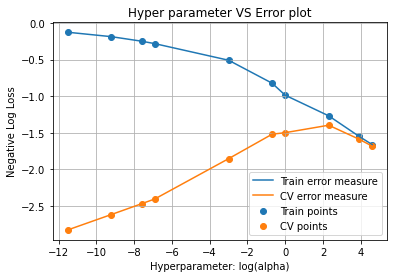

Best log loss: 1.397
Best parameters:  {'alpha': 10}
Best parameters (log transformed): 2.303


In [ ]:
# multinomial NB hyperparameter tuning (TF-IDF and OHE)
multi_nb = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
# ori scoring is roc_auc which don't support multiclass (error score allow detect error: https://stackoverflow.com/questions/60172458/sklearn-cross-val-score-returns-nan-values)
clf = RandomizedSearchCV(multi_nb, parameters, cv=3, scoring='neg_log_loss', return_train_score=True, random_state=42, error_score="raise")
clf.fit(X_train_tfidf_ohe, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV
results = results.sort_values(['param_alpha'])
train_score = results['mean_train_score']
train_score_std = results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(np.log(alpha.astype(float)), train_score, label='Train error measure') # reference: https://stackoverflow.com/questions/59297543/why-do-i-get-the-loop-of-ufunc-does-not-support-argument-0-of-type-int-error-f
plt.plot(np.log(alpha.astype(float)), cv_score, label='CV error measure')

plt.scatter(np.log(alpha.astype(float)), train_score, label='Train points')
plt.scatter(np.log(alpha.astype(float)), cv_score, label='CV points')

plt.legend()
plt.xlabel("Hyperparameter: log(alpha)")
plt.ylabel("Negative Log Loss")
plt.title("Hyper parameter VS Error plot")
plt.grid()
plt.show()
print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
print("Best parameters (log transformed): {:.3f}".format(np.log(clf.best_params_['alpha'])))
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

#### 8. Compute Performance Metrics with Best Hyperparameters

In [ ]:
def plot_perf_matrix(y_test, y_pred):
    '''
    Plot precision matrix and recall matrix given y_test, y_predicted
    '''
    C = confusion_matrix(y_test, y_pred)
    
    # recall (TPR/sensitivity) for class 1: of all points belonging to class 1, % of points predicted to be class 1
    # divide each element of CM with the sum of elements by row (row sums to 1)
    A =(((C.T)/(C.sum(axis=1))).T) 
    
    # precision for class 1: of all points predicted to be class 1, % of points actually belonging to class 1
    # divide each element of the CM with the sum of elements by col (col sums to 1)
    B =(C/C.sum(axis=0))
    
    labels = sorted(list(y_test.unique())) # create list of class labels (1 to 9)

#     print("Confusion Matrix", "-"*50)
#     plt.figure(figsize=(20,7))
#     sns.heatmap(C, annot=True, cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
#     plt.xlabel('Predicted Class')
#     plt.ylabel('Original Class')
#     plt.show()

    print("Precision Matrix (Columm Sum = 1)", "-"*80)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".2%", xticklabels=labels, yticklabels=labels) # fmt: https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("Recall Matrix (Row Sum = 1)", "-"*80)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".2%", xticklabels=labels, yticklabels=labels) # fmt: display % in 2 dp
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [ ]:
# https://stats.stackexchange.com/questions/276067/whats-considered-a-good-log-loss
# https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/
def predict_and_plot_perf_matrix(x_train, y_train, x_test, y_test, clf):
    '''
    Perform calibration, make predictions and plot perf metrics (precision matrix, recall matrix, % of misclassified pts)
    '''
    clf.fit(x_train, y_train)
    cccv = CalibratedClassifierCV(clf, cv='prefit', method="sigmoid")
    cccv.fit(x_train, y_train)
    y_pred = cccv.predict(x_test)
    y_pred_prob = cccv.predict_proba(x_test)
    
    log_loss_clf = log_loss(y_test, y_pred_prob) # log loss takes (y_true, y_pred) where y_pred is prob array for each class
    misclass_prop = np.count_nonzero((y_pred - y_test))/y_test.shape[0]

    print("Log loss: {:.3f}".format(log_loss_clf)) 
    print("% of misclassified points: {:.2%}".format(misclass_prop))
    # print("% of misclassified points: {}".format(round(100*misclass_prop,2))) # same result
    plot_perf_matrix(y_test, y_pred)
    return log_loss_clf, misclass_prop

Log loss: 1.255
% of misclassified points: 43.22%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


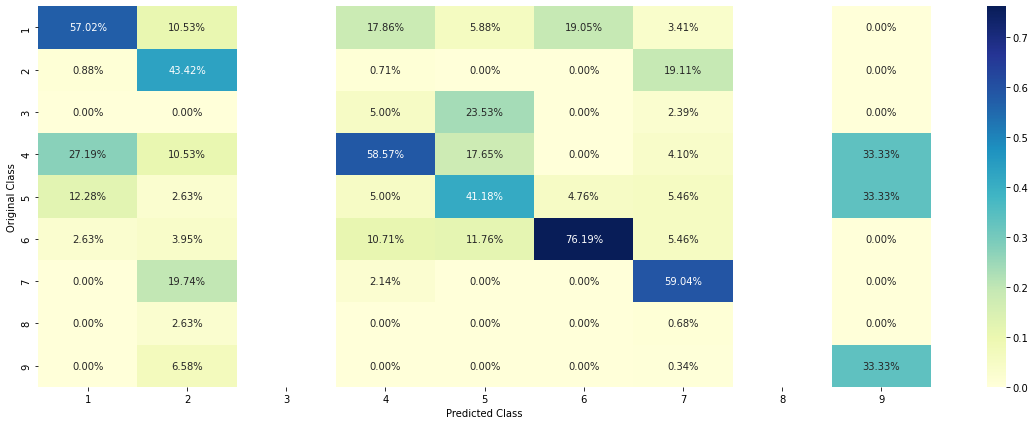

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


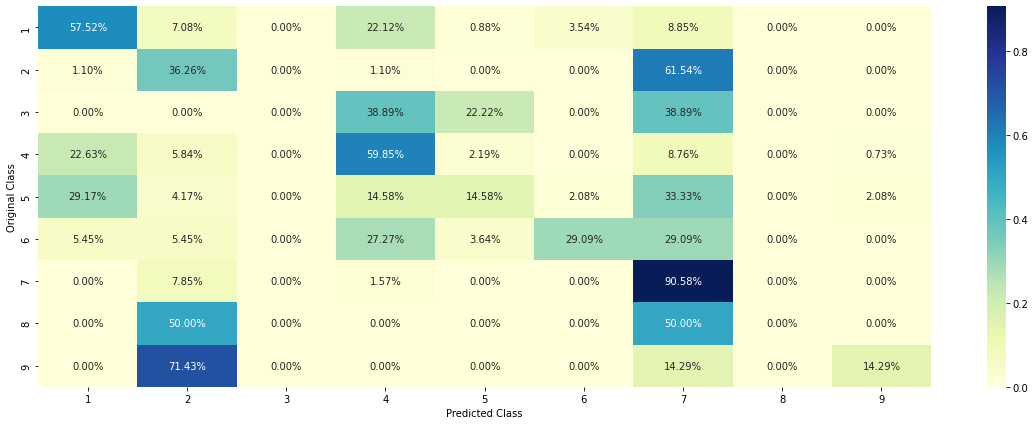

In [ ]:
best_alpha_nb = 10
multi_nb_clf = MultinomialNB(alpha=best_alpha)
log_loss_nb, misclass_prop_nb = predict_and_plot_perf_matrix(X_train_tfidf_ohe, y_train, X_test_tfidf_ohe, y_test, multi_nb_clf) # class 3,8,9 very few

>* The **precision** for the infrequent classes is very low. In particular for class 3 and 8, no points were predicted to belong to these 2 classes.
>* The **precision** for the other classes is not very high as well. For class 7 (which is the most frequent class) as an example, only 59% of all points predicted to be class 7 are actually class 7. The class with the highest precision is class 6.
>* Similarly, the **recall** for the infequent classes is very low. In particular for class 3 and 8, no points were predicted to belong to these 2 classes. For class 8 as an example, 50% of points were predicted to be class 2 while the remaining 50% were predicted to be class 7. With nill precision and recall, the Naive Bayes classifier is unable to identify class 3 and 8. 
>* The **recall** performance for the other classes is a mixed bag. For class 7 (which is the most frequent class), 91% of points belonging to class 7 were predicted to be class 7. On the other hand, only 15% of class 5 points were predicted to be class 5.

In [ ]:
# for model output interpretability purposes
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
def get_important_features_nb(test_index, clf, X_test_tfidf_ohe, y_test, X_test, top_n_features):
    """
    Given test query point into trained & calibrated NB clf, return predicted class, class prob and top words appearing in query
    For one hot encoded categorical features and NB clf only
    """
    predicted_class = clf.predict(X_test_tfidf_ohe[test_index])
    print("Predicted Class:", predicted_class[0]) # use [0] to get value without array brackets
    with np.printoptions(precision=3, suppress=True): # remove scientific notation - https://stackoverflow.com/questions/2891790/pretty-print-a-numpy-array-without-scientific-notation-and-with-given-precision
        print("Predicted Class Probabilities:", clf.predict_proba(X_test_tfidf_ohe[test_index]))
    print("Actual Class :", y_test.iloc[test_index])
    
    # get array of indices of top n features
    # [::-1] reverses the array returned by argsort() to desc order and [:n] gives that top n elements
    # predicted_class[0]-1 as class labels are 1 to 9 while indices are 0 to 8
    # log prob return array of shape (n_classes, n_features) for multiclass
    indices = np.argsort(clf.feature_log_prob_[predicted_class[0]-1])[::-1][:top_n_features]
    # log prob returns neg value (where higher value is stronger) 
    # print(indices) # for checking purposes
      
    # re-use initialized and trained vectorizer  
    len_gene =len(gene_vectorizer.get_feature_names())
    len_var =len(var_vectorizer.get_feature_names())
    
    word_present_count = 0
    # for ohe categorical features(X_test_tfidf_ohe), order of features is gene, var, text
    for i, feature_index in enumerate(indices):
        if feature_index < len_gene: # if index is less than len1, this means this feature is under gene
            word = gene_vectorizer.get_feature_names()[feature_index]
            ind = True if word == X_test['Gene'].iloc[test_index].lower() else False # lowercase Gene values
            if ind:
                word_present_count += 1
                print("{}. Gene feature {} [{}] present in test data point".format(i+1,feature_index,word))
            else:
                print("{}. Alert: Gene feature {} [{}] not present in test data point".format(i+1,feature_index,word))
        elif feature_index < len_gene + len_var: # if index is less than len1 + len2, this means this feature is under variation 
            word = var_vectorizer.get_feature_names()[feature_index - len_gene]
            ind = True if word == X_test['Variation'].iloc[test_index].lower() else False # lowercase Var values    
            if ind:
                word_present_count += 1
                print("{}. Variation feature {} [{}] present in test data point".format(i+1,feature_index,word))
            else:
                print("{}. Alert: Variation feature {} [{}] not present in test data point".format(i+1,feature_index,word))
        else: # if index is more than len1 + len2, then feature is under text
            word = tfidf_vectorizer.get_feature_names()[feature_index - len_gene - len_var]
            ind = True if word in X_test['TEXT'].iloc[test_index].split() else False
            if ind:
                word_present_count += 1
                print("{}. Text feature {} [{}] present in test data point".format(i+1,feature_index,word))
            else:
                print("{}. Alert: Text feature {} [{}] not present in test data point".format(i+1,feature_index,word))
    
    print("Out of the top {} features, {} are present in test query point".format(top_n_features, word_present_count))

In [ ]:
# let's test the prediction for a given test data point
get_important_features_nb(1, multi_nb_clf, X_test_tfidf_ohe, y_test, X_test, 15)

Predicted Class: 4
Predicted Class Probabilities: [[0.026 0.037 0.002 0.496 0.005 0.006 0.427 0.    0.   ]]
Actual Class : 1
[ 176 7183  230 6374   47   27 6709 3811 3601 8507  233 4949 3115 4722
 4723]
1. Gene feature 176 [pten] present in test data point
2. Text feature 7183 [pten] present in test data point
3. Alert: Gene feature 230 [tp53] not present in test data point
4. Text feature 6374 [mutations] present in test data point
5. Alert: Gene feature 47 [cdkn2a] not present in test data point
6. Alert: Gene feature 27 [brca1] not present in test data point
7. Alert: Text feature 6709 [p53] not present in test data point
8. Text feature 3811 [cells] present in test data point
9. Alert: Text feature 3601 [brca1] not present in test data point
10. Alert: Text feature 8507 [variants] not present in test data point
11. Alert: Gene feature 233 [tsc2] not present in test data point
12. Alert: Text feature 4949 [fig] not present in test data point
13. Text feature 3115 [activity] present 

> Taking a test point as an example above, it was misclassified as class 4 when the actual class was 1. From the class probabilities generated by the Naive Bayes classifier, it was a close call between class 4 and 7 (with the 2 highest probabilities at less than 0.5), but the actual class 1 probability was relatively low. This indicates the classifier was not particularly confident in its (incorrect) prediction. This is supported by the situation where less than half of top 15 features for class 4 was present in this data point.

### Section B: Random Forest

For Random Forest classifier, there are 2 sections: Part 1 where class weightage parameter is not used, and Part 2 where class weightage is used in an attempt to account for the class imbalance.

#### [Part 1] 7. Perform Hyperparameter Tuning

In [ ]:
rfc = RandomForestClassifier()
parameters = {'max_depth':[5, 10, 30],
              'n_estimators':[100,200,500,1000]} # 'min_samples_split':[5, 10, 100, 500]
# reduce n_iter from default of 10 as time taken to run default iter too long, and there are a total of 12 possible combination of hyperparameter values
clf = RandomizedSearchCV(rfc, parameters, cv=3, scoring='neg_log_loss', n_iter=6, return_train_score=True, random_state=42, error_score="raise", n_jobs=-1)
clf.fit(X_train_tfidf_te, y_train)

print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

Best log loss: 1.102
Best parameters:  {'n_estimators': 200, 'max_depth': 10}


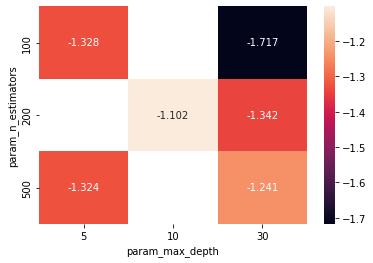

In [ ]:
# plot heatmap to visualise results of hyperparameter tuning
# ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV

max_scores = results.groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

#### [Part 1] 8. Compute Performance Metrics with Best Hyperparameters

Log loss: 1.078
% of misclassified points: 34.79%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


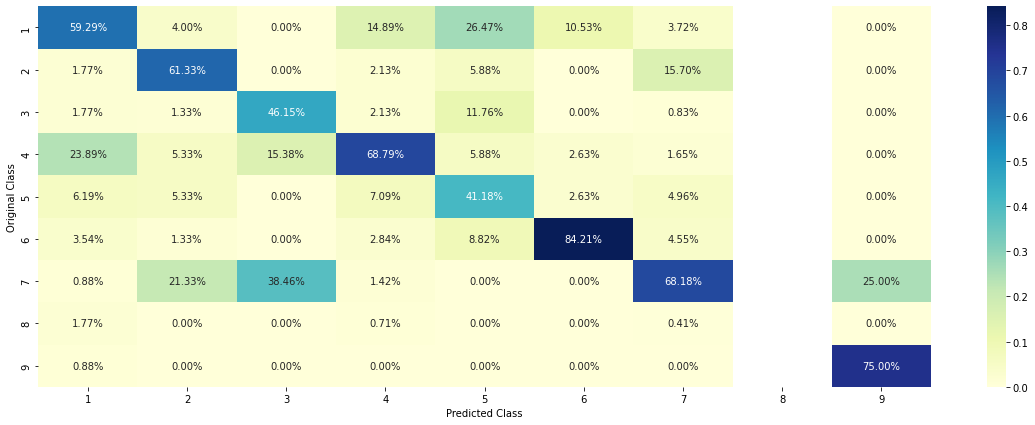

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


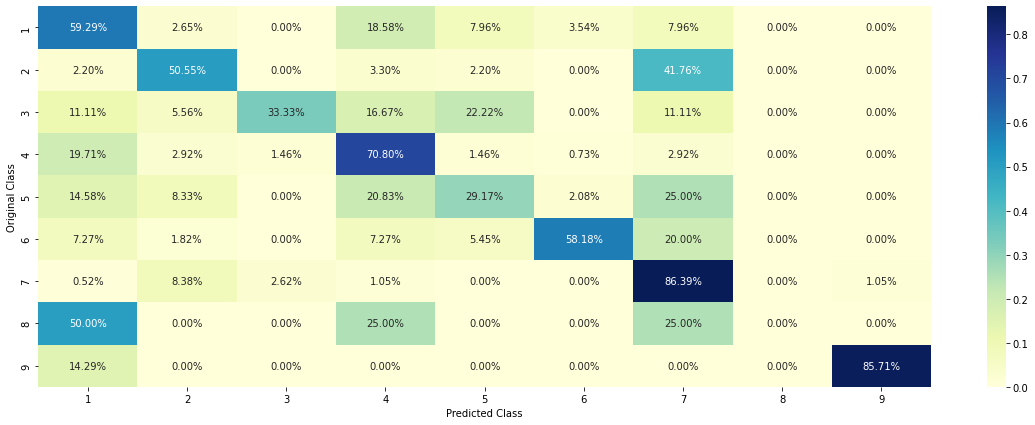

In [ ]:
best_n_est_rf = 200
best_depth_rf = 10
rf_clf = RandomForestClassifier(n_estimators=best_n_est, max_depth=best_depth, random_state=42)
log_loss_rf, misclass_prop_rf = predict_and_plot_perf_matrix(X_train_tfidf_te, y_train, X_test_tfidf_te, y_test, rf_clf) # class 3,8,9 very few

>* The **precision** for the infrequent classes is mixed. While class 9 has respectable precision, there is no score for class 8 as no points were predicted to belong to this class.
>* The **precision** for the other classes is respectable, except for class 5, where only 41% of points predicted to be class 5 are actually class 5. Similar to Naive Bayes, the class with the highest precision is class 6.
>* Similarly, the **recall** for the infequent classes is mixed. While class 9 has decent recall, class 8 has a score of 0. With nil precision and recall, the Random Forest Classifer is struggling to identify points as class 8.
>* The **recall** performance for the other classes is respectable. For class 7 (which is the most frequent class), 86% of points belonging to class 7 were predicted to be class 7. On the other hand, only 29% of class 5 points were predicted to be class 5.
>* Compared to the Naive Bayes classifer, the Random Forest classifer performed better across the board.

In [ ]:
# define function to intepret model output for TE features and tree based clf
def get_important_features_te(test_index, clf, X_test_tfidf_te, y_test, X_test, top_n_features):
    """
    Given test query point into trained & calibrated clf, return predicted class, class prob and top words appearing in query
    For response encoded categorical features and tree based clf only
    """
    predicted_class = clf.predict(X_test_tfidf_te[test_index])
    print("Predicted Class:", predicted_class[0]) # use [0] to get value without array brackets
    with np.printoptions(precision=3, suppress=True): # remove scientific notation - https://stackoverflow.com/questions/2891790/pretty-print-a-numpy-array-without-scientific-notation-and-with-given-precision
        print("Predicted Class Probabilities:", clf.predict_proba(X_test_tfidf_te[test_index]))
    print("Actual Class :", y_test.iloc[test_index])
    
    # get array of indices of top n features
    # [::-1] reverses the array returned by argsort() to desc order and [:n] gives that top n elements
    # don't need predicted_class[0]-1 like for NB as feature_importance return array of shape (no. of features,)
    indices = np.argsort(clf.feature_importances_)[::-1][:top_n_features]
    # print(indices) # for checking purposes
    
    # for te categorical features (X_test_tfidf_te), order of features is text, gene, var
    # word_present_count = 0
    for i, feature_index in enumerate(indices):
        if feature_index<6000:
            word = tfidf_vectorizer.get_feature_names()[feature_index]
            ind = True if word in X_test['TEXT'].iloc[test_index].split() else False
            if ind:
                # word_present_count += 1
                print("{}. Text feature {} [{}] is important feature, and present in test data point".format(i+1,feature_index,word))
            else:
                print("{}. Alert: Text feature {} [{}] is important feature, and not present in test data point".format(i+1,feature_index,word))                       
        elif feature_index==6000:
            print("{}. Gene is important feature".format(i+1))
        else:
            print("{}. Variation is important feature".format(i+1))

In [ ]:
get_important_features_te(1, rf_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 7
Predicted Class Probabilities: [[0.096 0.266 0.016 0.117 0.024 0.043 0.431 0.003 0.003]]
Actual Class : 1
[6000  423 6001 4206 3095 5720  426  425 3101 5616 3097 5721  419 1431
 4641]
1. Gene is important feature
2. Alert: Text feature 423 [activating] is important feature, and not present in test data point
3. Variation is important feature
4. Text feature 4206 [phosphorylation] is important feature, and present in test data point
5. Text feature 3095 [kinase] is important feature, and present in test data point
6. Text feature 5720 [tyrosine] is important feature, and present in test data point
7. Text feature 426 [activation] is important feature, and present in test data point
8. Alert: Text feature 425 [activating mutations] is important feature, and not present in test data point
9. Alert: Text feature 3101 [kinase domain] is important feature, and not present in test data point
10. Text feature 5616 [treatment] is important feature, and present in test data po

> Taking a test point as an example above, it was misclassified as class 7 when the actual class was 1. From the class probabilities generated by the Random Forest classifier, class 7 had the highest probability at less than 0.5, with actual class 1 probability trailing at a distant fourth highest probability. This suggests the classifier was not very confident in its (incorrect) prediction, despite the data point having almost half of the important text features. 

In [ ]:
get_important_features_te(2, rf_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 1
Predicted Class Probabilities: [[0.5   0.054 0.013 0.25  0.043 0.038 0.075 0.007 0.019]]
Actual Class : 1
[6000  423 6001 4206 3095 5720  426  425 3101 5616 3097 5721  419 1431
 4641]
1. Gene is important feature
2. Alert: Text feature 423 [activating] is important feature, and not present in test data point
3. Variation is important feature
4. Alert: Text feature 4206 [phosphorylation] is important feature, and not present in test data point
5. Alert: Text feature 3095 [kinase] is important feature, and not present in test data point
6. Alert: Text feature 5720 [tyrosine] is important feature, and not present in test data point
7. Text feature 426 [activation] is important feature, and present in test data point
8. Alert: Text feature 425 [activating mutations] is important feature, and not present in test data point
9. Alert: Text feature 3101 [kinase domain] is important feature, and not present in test data point
10. Text feature 5616 [treatment] is important fea

>Taking a test point as an example above, it was correctly classified as class 1. From the class probabilities generated by the Random Forest classifier, class 1 had the highest probability, far ahead of other classes. This indicates the classifier was relatively confident in its (correct) prediction, although this data point did not have most of the important text features.

#### [Part 2] 7. Perform Hyperparameter Tuning (with class weight)

In [ ]:
# balanced class weight (classes weighted inversely proportional to how frequently they appear in the data) - perf seems worse
# https://stackoverflow.com/questions/58275113/proper-use-of-class-weight-parameter-in-random-forest-classifier
rfc = RandomForestClassifier(class_weight='balanced')
parameters = {'max_depth':[5, 10, 30],
              'n_estimators':[100,200,500,1000]}
# reduce n_iter from default of 10 as time taken to run default iter too long, and there are a total of 12 possible combination of hyperparameter values
clf = RandomizedSearchCV(rfc, parameters, cv=3, scoring='neg_log_loss', n_iter=6, return_train_score=True, random_state=42, error_score="raise", n_jobs=-1)
clf.fit(X_train_tfidf_te, y_train)

print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

Best log loss: 1.289
Best parameters:  {'n_estimators': 500, 'max_depth': 30}


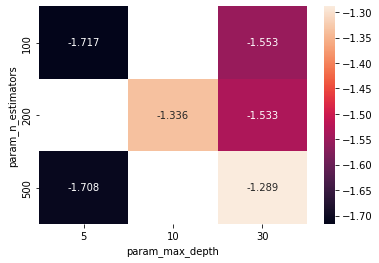

In [ ]:
# plot heatmap to visualise results of hyperparameter tuning
# ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV

max_scores = results.groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

#### [Part 2] 8. Compute Performance Metrics with Best Hyperparameters (with class weight)

Log loss: 1.234
% of misclassified points: 35.99%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


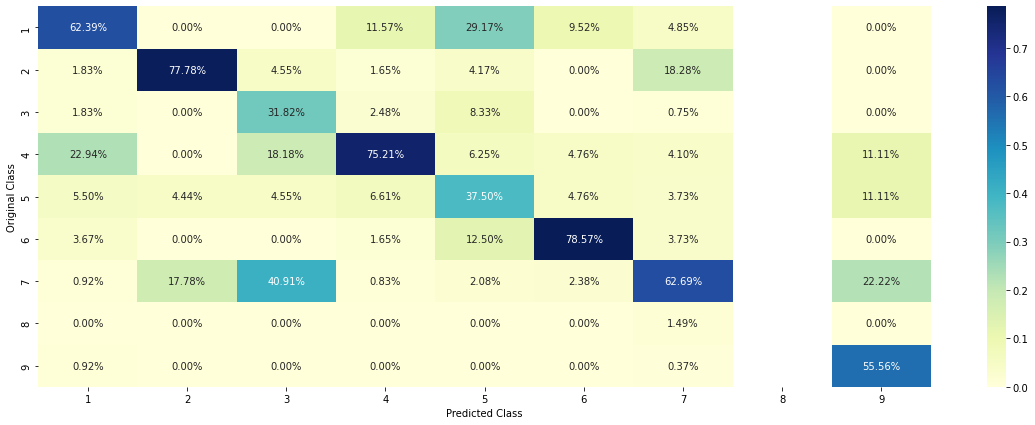

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


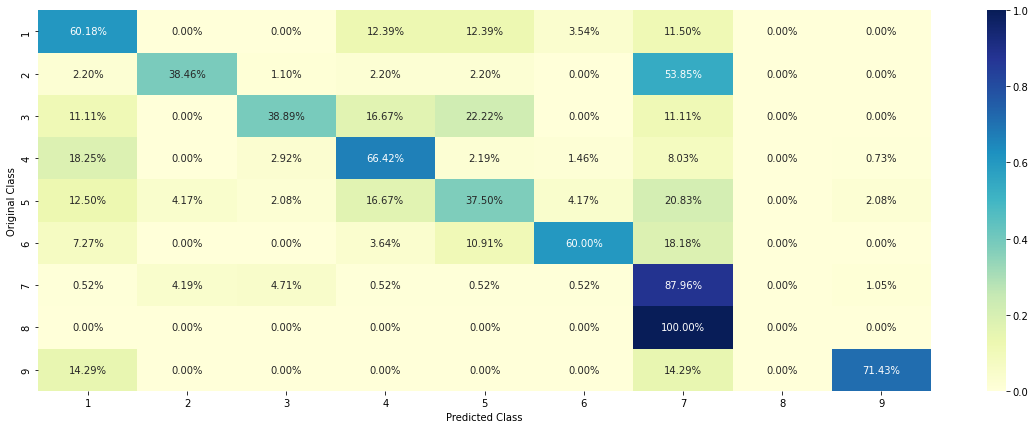

In [ ]:
# try balanced class weight (classes weighted inversely proportional to how frequently they appear in the data) using hyperparameters with class weight
# https://stackoverflow.com/questions/58275113/proper-use-of-class-weight-parameter-in-random-forest-classifier
best_depth = 30
rf_clf = RandomForestClassifier(n_estimators=best_n_est, max_depth=best_depth, class_weight ='balanced', random_state=42)
log_loss_rf, misclass_prop_rf = predict_and_plot_perf_matrix(X_train_tfidf_te, y_train, X_test_tfidf_te, y_test, rf_clf) # class 3,8,9 very few

>* The **precision** for the infrequent classes is decent, albeit weaker compared to the Random Forest classifier without class weight.
>* The **precision** for the other classes is respectable, except for class 3 and 5, where less than half of points predicted to be in those classes actually belonging to the respective class. Similar to Naive Bayes and Random Forest classifer without class weight, the class with the highest precision is class 6. Notably, the precision for class 1,2 and 4 is better than the Random Forest classifer without class weight, while worse for class 5,6 and 7.
>* Similarly, the **recall** for the infequent classes is mixed. While class 9 has decent recall (although weaker compared to the Random Forest classifier without class weight), class 8 has a score of 0. With nil precision and recall, the Random Forest Classifer is struggling to identify points as class 8.
>* The **recall** performance for the other classes is respectable, with mixed results compared to the Random Forest classifier without class weight. For instance, the recall for class 2 is only 38% (versus 51% in the previous Random Forest). For class 7 (which is the most frequent class), the recall is marginally better, with 88% of points belonging to class 7 were predicted to be class 7.
>* The Random Forest classifier with class weight appears to performed worse compared to the Random Forest classifier without class weight.

In [ ]:
get_important_features_te(1, rf_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 2
Predicted Class Probabilities: [[0.122 0.281 0.041 0.116 0.075 0.085 0.255 0.012 0.012]]
Actual Class : 1
[6000 3095 5021 3439 5212 6001 5729  590 5182  925 2184 2953 4821 4852
  372]
1. Gene is important feature
2. Text feature 3095 [kinase] is important feature, and present in test data point
3. Alert: Text feature 5021 [sf3b1] is important feature, and not present in test data point
4. Alert: Text feature 3439 [mds] is important feature, and not present in test data point
5. Alert: Text feature 5212 [srsf2] is important feature, and not present in test data point
6. Variation is important feature
7. Alert: Text feature 5729 [u2af1] is important feature, and not present in test data point
8. Alert: Text feature 590 [alternative splicing] is important feature, and not present in test data point
9. Text feature 5182 [specific] is important feature, and present in test data point
10. Alert: Text feature 925 [brca1] is important feature, and not present in test data po

> Taking a test point as an example above, it was misclassified as class 2 when the actual class was 1. From the class probabilities generated by the Random Forest classifier with class weight, class 2 and 7 had the highest probabilities at less than 0.5 each, with actual class 1 probability trailing behind. This suggests the classifier was not very confident in its (incorrect) prediction, supported by the situation where many of the important text features were not present in this data point.

In [ ]:
get_important_features_te(2, rf_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 1
Predicted Class Probabilities: [[0.331 0.102 0.062 0.201 0.09  0.08  0.105 0.004 0.025]]
Actual Class : 1
[6000 3095 5021 3439 5212 6001 5729  590 5182  925 2184 2953 4821 4852
  372]
1. Gene is important feature
2. Alert: Text feature 3095 [kinase] is important feature, and not present in test data point
3. Alert: Text feature 5021 [sf3b1] is important feature, and not present in test data point
4. Alert: Text feature 3439 [mds] is important feature, and not present in test data point
5. Alert: Text feature 5212 [srsf2] is important feature, and not present in test data point
6. Variation is important feature
7. Alert: Text feature 5729 [u2af1] is important feature, and not present in test data point
8. Alert: Text feature 590 [alternative splicing] is important feature, and not present in test data point
9. Text feature 5182 [specific] is important feature, and present in test data point
10. Alert: Text feature 925 [brca1] is important feature, and not present in t

>Taking a test point as an example above, it was correctly classified as class 1. From the class probabilities generated by the Random Forest classifier, class 1 had the highest probability, ahead of other classes. This indicates the classifier was relatively confident in its (correct) prediction, although this data point did not have many important text features.

#### [Bonus] Random Forest with Dimensionality Reduction

Even with target encoding for categorical features, the dimensionality of the dataset is large, relative to the no. of data points. This affects the performance of tree based models, since there is a need to evaluate each feature for information gain. Let's evaluate the performance of Random Forest after applying dimension reduction on the dataset. 

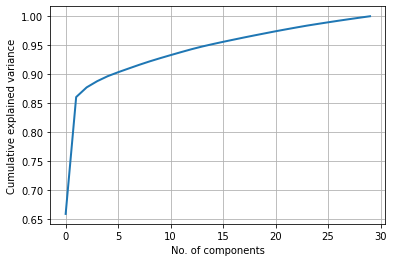

In [ ]:
# implement PCA
# https://www.kaggle.com/code/parulpandey/visualizing-kannada-mnist-with-t-sne/notebook
# https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
x_train_pca = pca.fit_transform(X_train_tfidf_te.todense())
x_test_pca = pca.transform(X_test_tfidf_te.todense())

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
# plt.figure(1, figsize=(6, 4))

plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('No. of components')
plt.ylabel('Cumulative explained variance')
plt.show()
# 5 components explain approx 90% of variance - let's try using the top 15 components

In [ ]:
# convert to df with column names
X_train_pca = pd.DataFrame(x_train_pca[:,:15])
X_test_pca = pd.DataFrame(x_test_pca[:,:15])

n_components=15
X_train_pca.columns = X_test_pca.columns = ['component_{}'.format(i) for i in range(1, n_components + 1)]
X_train_pca.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15
0,1.772111,0.175877,-0.072195,0.008770,-0.116740,-0.011841,-0.075366,-0.031657,0.051034,-0.123004,-0.160114,-0.043797,-0.124460,-0.052693,0.233367
1,-0.438129,-0.224433,-0.169283,0.861623,0.099301,-0.006962,0.000145,0.021584,0.002778,0.014026,0.030239,-0.044411,0.054122,0.044640,-0.018148
2,-0.192235,-0.172014,-0.040513,-0.007475,-0.052261,-0.009767,0.022726,-0.042804,0.035144,-0.001419,-0.027488,0.047649,-0.048093,0.041704,-0.059625
3,-0.614057,-0.246404,0.033826,-0.059568,-0.104667,-0.063945,-0.130314,0.135337,0.044800,0.017896,0.043264,0.039018,0.348241,-0.090909,0.042845
4,-0.591660,3.100179,-0.026955,0.004912,-0.075402,0.048837,-0.015623,-0.036228,-0.021424,0.003684,-0.042062,0.015240,-0.043872,0.027944,-0.023617


In [ ]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(2652, 15)
(664, 15)


In [ ]:
rfc = RandomForestClassifier()
parameters = {'max_depth':[5, 10, 30],
              'n_estimators':[100,200,500,1000]} # 'min_samples_split':[5, 10, 100, 500]
# reduce n_iter from default of 10 as time taken to run default iter too long, and there are a total of 12 possible combination of hyperparameter values
clf = RandomizedSearchCV(rfc, parameters, cv=3, scoring='neg_log_loss', n_iter=6, return_train_score=True, random_state=42, error_score="raise", n_jobs=-1)
clf.fit(X_train_pca, y_train)

print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

Best log loss: 0.983
Best parameters:  {'n_estimators': 200, 'max_depth': 10}


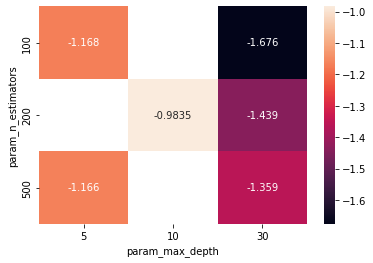

In [ ]:
# plot heatmap to visualise results of hyperparameter tuning
# ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV

max_scores = results.groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

Log loss: 1.110
% of misclassified points: 36.30%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


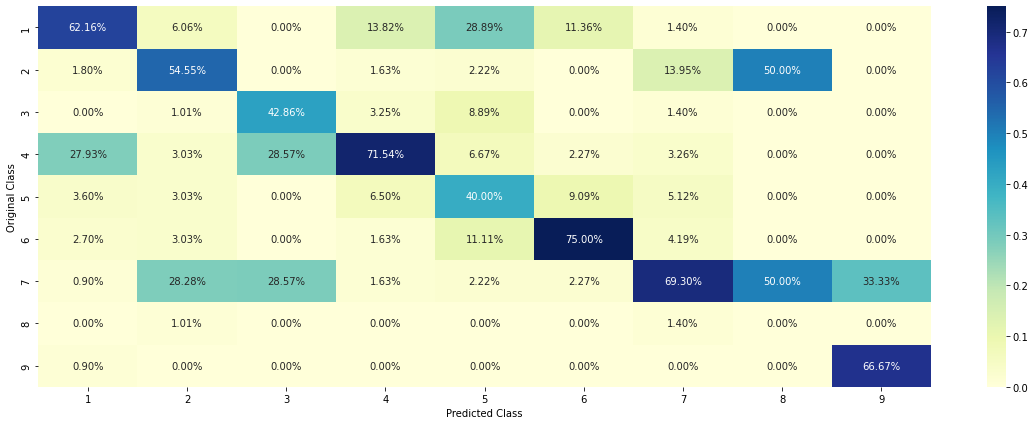

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


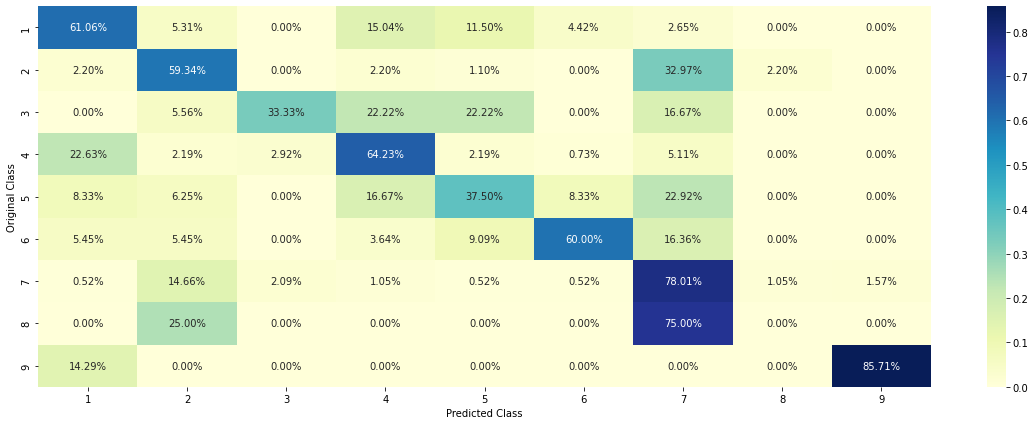

In [ ]:
best_n_est = 200
best_depth = 10
rf_clf = RandomForestClassifier(n_estimators=best_n_est, max_depth=best_depth, random_state=42) #class_weight ='balanced'
log_loss_rf, misclass_prop_rf = predict_and_plot_perf_matrix(X_train_pca, y_train, X_test_pca, y_test, rf_clf) # class 3,8,9 very few

>* Compared to the Random Forest classifier trained on data without PCA, the classifier trained on data with PCA has slightly worse performance in terms of log loss and proportion of misclassified points.
>* The **precision** for each class is generally comparable to the previous Random Forest. In this case, the classifier even predicted some points as belonging to class 8 (compared to none in the previous Random Forest), although they were all misclassified.
>* Similarly, the **recall** for each class is comparable to the previous Random Forest. With nil precision and recall, the Random Forest classifer trained on data with PCA is still struggling to identify points as class 8.

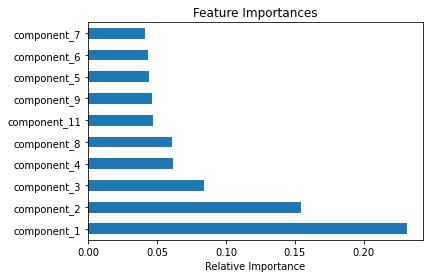

In [ ]:
# https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train_pca.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.title('Feature Importances');

In [ ]:
# define function to intepret model output for TE features and tree based clf
def get_important_features_pca(test_index, clf, X_test_pca, y_test, top_n_features):
    """
    Given test query point into trained & calibrated clf, return predicted class, class prob and top words appearing in query
    For response encoded categorical features and tree based clf only
    """
    # use iloc as X_test_pca is df, convert to array and reshape to 2D as single sample
    predicted_class = clf.predict(np.array(X_test_pca.iloc[test_index]).reshape(1, -1))
    print("Predicted Class:", predicted_class[0]) # use [0] to get value without array brackets
    with np.printoptions(precision=3, suppress=True): # remove scientific notation - https://stackoverflow.com/questions/2891790/pretty-print-a-numpy-array-without-scientific-notation-and-with-given-precision
        print("Predicted Class Probabilities:", clf.predict_proba(np.array(X_test_pca.iloc[test_index]).reshape(1, -1)))
    print("Actual Class :", y_test.iloc[test_index])
    
    # get array of indices of top n features
    # [::-1] reverses the array returned by argsort() to desc order and [:n] gives that top n elements
    # don't need predicted_class[0]-1 like for NB as feature_importance return array of shape (no. of features,)
    indices = np.argsort(clf.feature_importances_)[::-1][:top_n_features]
    # print(indices) # for checking purposes
    
    print("The top {} features are as follows:".format(top_n_features))
    for i, feature_index in enumerate(indices):
        print("{}. Principal component {}".format(i+1, feature_index+1))

In [ ]:
get_important_features_pca(1, rf_clf, X_test_pca, y_test, 10)

Predicted Class: 4
Predicted Class Probabilities: [[0.208 0.247 0.006 0.275 0.059 0.063 0.141 0.001 0.   ]]
Actual Class : 1
The top 10 features are as follows:
1. Principal component 1
2. Principal component 2
3. Principal component 3
4. Principal component 4
5. Principal component 8
6. Principal component 11
7. Principal component 9
8. Principal component 5
9. Principal component 6
10. Principal component 7


In [ ]:
get_important_features_pca(2, rf_clf, X_test_pca, y_test, 10)

Predicted Class: 1
Predicted Class Probabilities: [[0.757 0.005 0.001 0.201 0.013 0.019 0.001 0.    0.002]]
Actual Class : 1
The top 10 features are as follows:
1. Principal component 1
2. Principal component 2
3. Principal component 3
4. Principal component 4
5. Principal component 8
6. Principal component 11
7. Principal component 9
8. Principal component 5
9. Principal component 6
10. Principal component 7


>* As observed in the feature importance chart above and when interpreting the model output for a few test points, the results are not easily interpretable due to PCA.
>* Dimensionality reduction may reduce the runtime complexity, but at the cost of model interpretability. In our case, the Random Forest classifier also did not perform better on data with PCA.

### Section C: Logistic Regression

#### [Part 1] 7. Perform Hyperparameter Tuning

For logistic regression, there are 2 sections: Part 1 where class weightage parameter is not used, and Part 2 where class weightage is used in an attempt to account for the class imbalance.

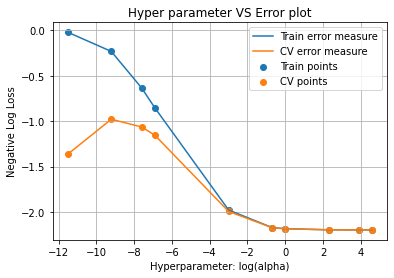

Best log loss: 0.978
Best parameters:  {'alpha': 0.0001}
Best parameters (log transformed): -9.210


In [ ]:
# logistic regression hyperparameter tuning (TF-IDF and OHE)
log_reg = SGDClassifier(loss='log')
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
# ori scoring is roc_auc which don't support multiclass (error score allow detect error: https://stackoverflow.com/questions/60172458/sklearn-cross-val-score-returns-nan-values)
clf = RandomizedSearchCV(log_reg, parameters, cv=3, scoring='neg_log_loss', return_train_score=True, random_state=42, error_score="raise")
clf.fit(X_train_tfidf_ohe, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV
results = results.sort_values(['param_alpha'])
train_score = results['mean_train_score']
train_score_std = results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(np.log(alpha.astype(float)), train_score, label='Train error measure') # reference: https://stackoverflow.com/questions/59297543/why-do-i-get-the-loop-of-ufunc-does-not-support-argument-0-of-type-int-error-f
plt.plot(np.log(alpha.astype(float)), cv_score, label='CV error measure')

plt.scatter(np.log(alpha.astype(float)), train_score, label='Train points')
plt.scatter(np.log(alpha.astype(float)), cv_score, label='CV points')

plt.legend()
plt.xlabel("Hyperparameter: log(alpha)")
plt.ylabel("Negative Log Loss")
plt.title("Hyper parameter VS Error plot")
plt.grid()
plt.show()
print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
print("Best parameters (log transformed): {:.3f}".format(np.log(clf.best_params_['alpha'])))
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

#### [Part 2] 8. Compute Performance Metrics with Best Hyperparameters

Log loss: 2.140
% of misclassified points: 34.79%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


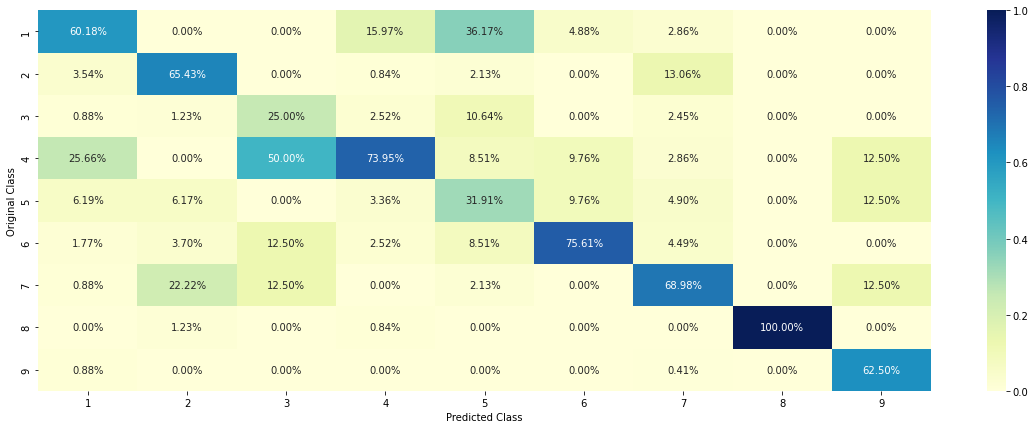

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


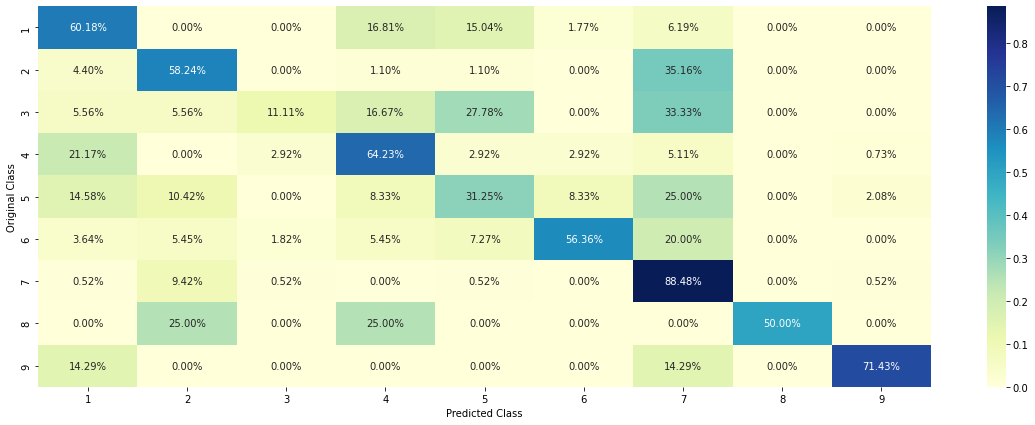

In [ ]:
best_alpha = 0.0001
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, random_state=42)
log_loss_sgd, misclass_prop_sgd = predict_and_plot_perf_matrix(X_train_tfidf_ohe, y_train, X_test_tfidf_ohe, y_test, sgd_clf) # class 3,8,9 very few

>* The **precision** for the infrequent classes is mixed. While class 3 has low precision, class 8 notably has perfect precision. The Random Forest and Naive Bayes classifiers above had nil precision for class 8. 
>* The **precision** for the other classes is respectable, except for class 5, where only 32% of points predicted to be class 5 are actually class 5.
>* Similarly, the **recall** for the infequent classes is mixed. Class 8 has recall of 50%, compared to 0% for Random Forest and Naive Bayes. However, recall for class 3 is poorer. 
>* The **recall** performance for the other classes is respectable. For class 7 (which is the most frequent class), 88% of points belonging to class 7 were predicted to be class 7. On the other hand, only 31% of class 5 points were predicted to be class 5.
>* So far compared to Random Forest and Naive Bayes, logistic regression performs better for rare classes and returns comparable overall proportion of correctly classified points. However, the log loss is noticebly higher, suggesting that logistic regression is overconfident in some of its incorrect predictions, and/or not very confident in some of its correct predictions.

#### [Part 2] 7. Perform Hyperparameter Tuning (with class weight)

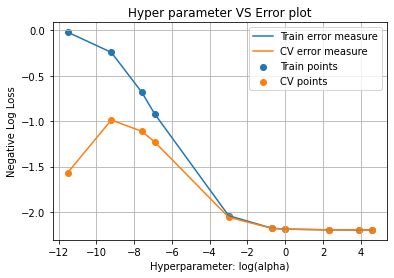

Best log loss: 0.987
Best parameters:  {'alpha': 0.0001}
Best parameters (log transformed): -9.210


In [ ]:
# logistic regression hyperparameter tuning (TF-IDF and OHE)
# balanced class weight (classes weighted inversely proportional to how frequently they appear in the data)
log_reg = SGDClassifier(loss='log',class_weight='balanced')
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
# ori scoring is roc_auc which don't support multiclass (error score allow detect error: https://stackoverflow.com/questions/60172458/sklearn-cross-val-score-returns-nan-values)
clf = RandomizedSearchCV(log_reg, parameters, cv=3, scoring='neg_log_loss', return_train_score=True, random_state=42, error_score="raise")
clf.fit(X_train_tfidf_ohe, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV
results = results.sort_values(['param_alpha'])
train_score = results['mean_train_score']
train_score_std = results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(np.log(alpha.astype(float)), train_score, label='Train error measure') # reference: https://stackoverflow.com/questions/59297543/why-do-i-get-the-loop-of-ufunc-does-not-support-argument-0-of-type-int-error-f
plt.plot(np.log(alpha.astype(float)), cv_score, label='CV error measure')

plt.scatter(np.log(alpha.astype(float)), train_score, label='Train points')
plt.scatter(np.log(alpha.astype(float)), cv_score, label='CV points')

plt.legend()
plt.xlabel("Hyperparameter: log(alpha)")
plt.ylabel("Negative Log Loss")
plt.title("Hyper parameter VS Error plot")
plt.grid()
plt.show()
print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
print("Best parameters (log transformed): {:.3f}".format(np.log(clf.best_params_['alpha'])))
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

#### [Part 2] 8. Compute Performance Metrics with Best Hyperparameters (with class weight)

Log loss: 1.969
% of misclassified points: 33.58%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


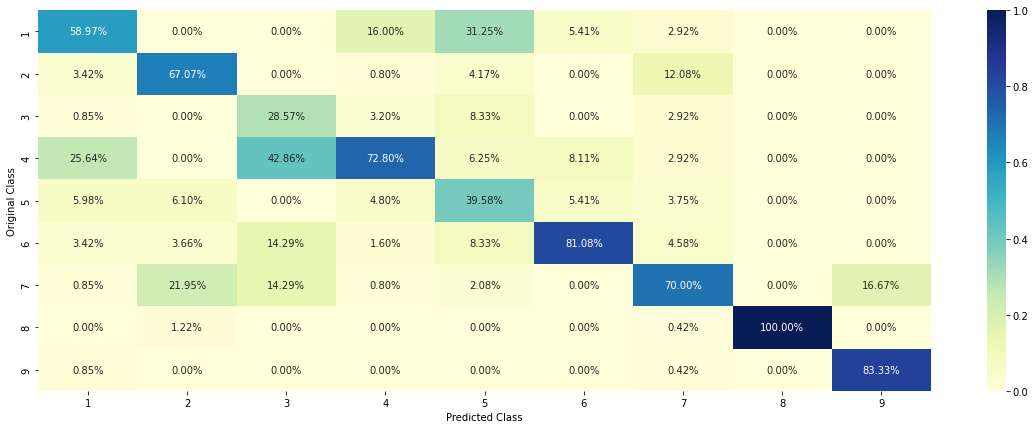

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


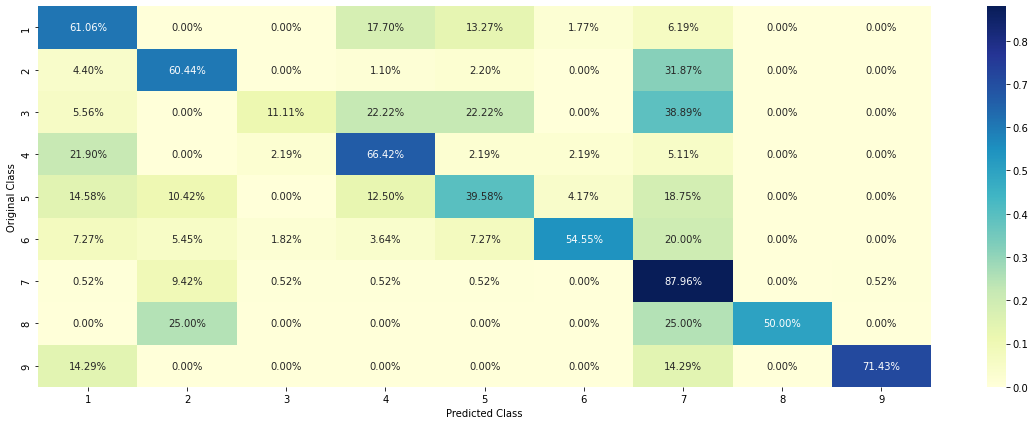

In [ ]:
# try balanced class weight (classes weighted inversely proportional to how frequently they appear in the data) using hyperparameters with class weight - worse perf
# https://stackoverflow.com/questions/58275113/proper-use-of-class-weight-parameter-in-random-forest-classifier
best_alpha = 0.0001
sgd_clf = SGDClassifier(loss='log',class_weight='balanced', alpha=best_alpha, random_state=42)
log_loss_sgd, misclass_prop_sgd = predict_and_plot_perf_matrix(X_train_tfidf_ohe, y_train, X_test_tfidf_ohe, y_test, sgd_clf) # class 3,8,9 very few

>* Compared to logistic regression without class weight, the **precision** across classes is generally slightly higher. 
>* Similarly, the **recall** is slightly better as well.
>* Unlike for Random Forest, logistic regression with class weight performed better in almost every dimension, compared to logistic regression without class weight. 
>* Compared to the earlier Random Forest and Naive Bayes classifiers, this version of logistic regression with class weight has the best performance in terms of overall proportion of correctly classified points and for rare classes so far. However, the log loss is still higher (although better than logistic regression without class weight). 

In [ ]:
# define function to intepret model output for OHE features and sgd based clf
def get_important_features_sgd(test_index, clf, X_test_tfidf_ohe, y_test, X_test, top_n_features):
    """
    Given test query point into trained & calibrated clf, return predicted class, class prob and top words appearing in query
    For one hot encoded categorical features and logistic regression clf only
    """
    predicted_class = clf.predict(X_test_tfidf_ohe[test_index])
    print("Predicted Class:", predicted_class[0]) # use [0] to get value without array brackets
    with np.printoptions(precision=3, suppress=True): # remove scientific notation - https://stackoverflow.com/questions/2891790/pretty-print-a-numpy-array-without-scientific-notation-and-with-given-precision
        print("Predicted Class Probabilities:", clf.predict_proba(X_test_tfidf_ohe[test_index]))
    print("Actual Class :", y_test.iloc[test_index])
    
    # get array of indices of top n features
    # [::-1] reverses the array returned by argsort() to desc order and [:n] gives that top n elements
    # predicted_class[0]-1 as class labels are 1 to 9 while indices are 0 to 8
    # coef return array of shape (n_classes, n_features) for multiclass, for binary class (1, n_features)
    indices = np.argsort(clf.coef_[predicted_class[0]-1])[::-1][:top_n_features]
    # log prob returns neg value (where higher value is stronger) 
    # print(indices) # for checking purposes
      
    # re-use initialized and trained vectorizer  
    len_gene =len(gene_vectorizer.get_feature_names())
    len_var =len(var_vectorizer.get_feature_names())
    
    word_present_count = 0
    # for ohe categorical features(X_test_tfidf_ohe), order of features is gene, var, text
    for i, feature_index in enumerate(indices):
        if feature_index < len_gene: # if index is less than len1, this means this feature is under gene
            word = gene_vectorizer.get_feature_names()[feature_index]
            ind = True if word == X_test['Gene'].iloc[test_index].lower() else False # lowercase Gene values
            if ind:
                word_present_count += 1
                print("{}. Gene feature {} [{}] present in test data point".format(i+1,feature_index,word))
            else:
                print("{}. Alert: Gene feature {} [{}] not present in test data point".format(i+1,feature_index,word))
        elif feature_index < len_gene + len_var: # if index is less than len1 + len2, this means this feature is under variation 
            word = var_vectorizer.get_feature_names()[feature_index - len_gene]
            ind = True if word == X_test['Variation'].iloc[test_index].lower() else False # lowercase Var values    
            if ind:
                word_present_count += 1
                print("{}. Variation feature {} [{}] present in test data point".format(i+1,feature_index,word))
            else:
                print("{}. Alert: Variation feature {} [{}] not present in test data point".format(i+1,feature_index,word))
        else: # if index is more than len1 + len2, then feature is under text
            word = tfidf_vectorizer.get_feature_names()[feature_index - len_gene - len_var]
            ind = True if word in X_test['TEXT'].iloc[test_index].split() else False
            if ind:
                word_present_count += 1
                print("{}. Text feature {} [{}] present in test data point".format(i+1,feature_index,word))
            else:
                print("{}. Alert: Text feature {} [{}] not present in test data point".format(i+1,feature_index,word))
    
    print("Out of the top {} features, {} are present in test query point".format(top_n_features, word_present_count))

In [ ]:
get_important_features_sgd(1, sgd_clf, X_test_tfidf_ohe, y_test, X_test, 15)

Predicted Class: 4
Predicted Class Probabilities: [[0.013 0.02  0.005 0.826 0.026 0.04  0.06  0.005 0.005]]
Actual Class : 1
1. Alert: Gene feature 145 [nf1] not present in test data point
2. Gene feature 176 [pten] present in test data point
3. Alert: Text feature 3601 [brca1] not present in test data point
4. Alert: Gene feature 47 [cdkn2a] not present in test data point
5. Alert: Gene feature 48 [cdkn2b] not present in test data point
6. Alert: Text feature 8162 [tgf] not present in test data point
7. Alert: Gene feature 115 [keap1] not present in test data point
8. Alert: Variation feature 1946 [r2659k] not present in test data point
9. Alert: Variation feature 1921 [r2336h] not present in test data point
10. Alert: Text feature 6105 [mc] not present in test data point
11. Alert: Variation feature 785 [e866k] not present in test data point
12. Alert: Variation feature 1199 [i853t] not present in test data point
13. Alert: Gene feature 137 [msh2] not present in test data point
14. A

In [ ]:
get_important_features_sgd(2, sgd_clf, X_test_tfidf_ohe, y_test, X_test, 15)

Predicted Class: 1
Predicted Class Probabilities: [[0.753 0.007 0.004 0.18  0.016 0.024 0.007 0.002 0.007]]
Actual Class : 1
1. Alert: Variation feature 2393 [truncating_mutations] not present in test data point
2. Alert: Variation feature 632 [deletion] not present in test data point
3. Alert: Text feature 5453 [hotspots] not present in test data point
4. Alert: Variation feature 2081 [r841k] not present in test data point
5. Alert: Variation feature 2555 [w349c] not present in test data point
6. Alert: Gene feature 190 [rasa1] not present in test data point
7. Alert: Variation feature 918 [g129a] not present in test data point
8. Text feature 3172 [aggregation] present in test data point
9. Alert: Variation feature 319 [a4419s] not present in test data point
10. Alert: Variation feature 1789 [q510e] not present in test data point
11. Alert: Variation feature 2424 [v1688del] not present in test data point
12. Alert: Variation feature 2294 [t1481fs] not present in test data point
13. A

### Section D: XGBoost

#### [Part 1] 7. Perform Hyperparameter Tuning

For XGBoost classifier, there are 2 sections: Part 1 where class weightage parameter is not used, and Part 2 where class weightage is used in an attempt to account for the class imbalance.

In [ ]:
xgb_ht = xgb.XGBClassifier()
parameters = {'max_depth':[5, 10, 30],
              'n_estimators':[100,200,500,1000]} # 'colsample_bytree': [0.5, 0.75, 1]
# reduce n_iter from default of 10 as time taken to run default iter too long, and there are a total of 12 possible combination of hyperparameter values
clf = RandomizedSearchCV(xgb_ht, parameters, cv=3, scoring='neg_log_loss', n_iter=6, return_train_score=True, random_state=42, error_score="raise", n_jobs=-1)
clf.fit(X_train_tfidf_te, y_train)

print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

[19:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best log loss: 1.219
Best parameters:  {'n_estimators': 100, 'max_depth': 5}


#### [Part 1] 8. Compute Performance Metrics with Best Hyperparameters

[14:03:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Log loss: 1.346
% of misclassified points: 34.19%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


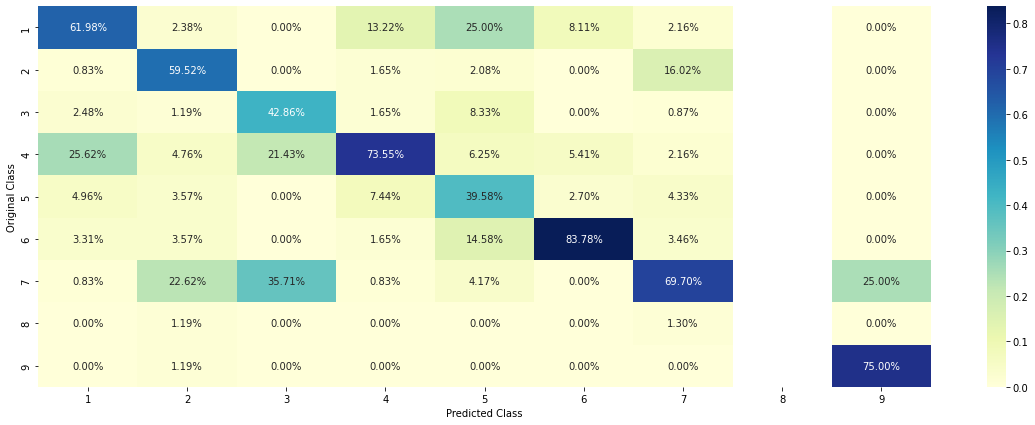

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


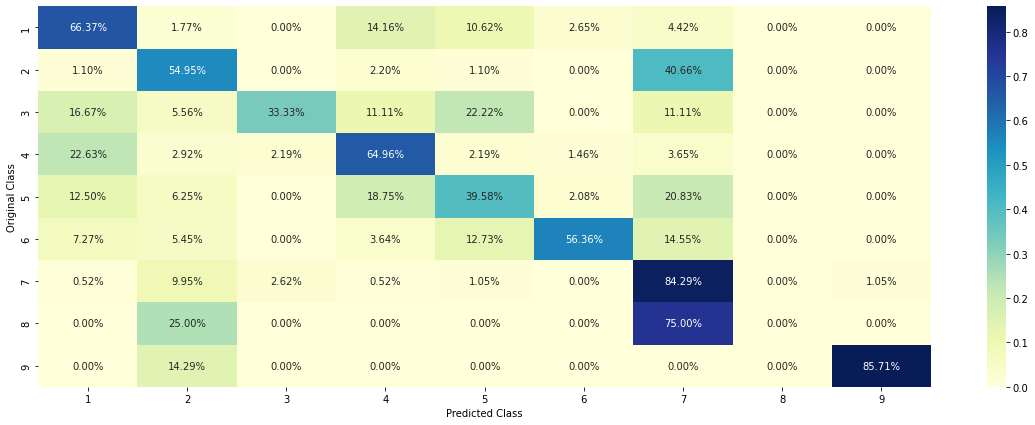

In [ ]:
best_n_est = 100
best_depth = 5
xgb_clf = xgb.XGBClassifier(n_estimators=best_n_est, max_depth=best_depth, random_state=42) # nthread=-1
log_loss_xgb, misclass_prop_xgb = predict_and_plot_perf_matrix(X_train_tfidf_te, y_train, X_test_tfidf_te, y_test, xgb_clf) # class 3,8,9 very few

# https://stackoverflow.com/questions/65517931/xgboost-not-running-with-callibrated-classifier
# xgb cccv: https://stackoverflow.com/questions/61508945/how-to-use-calibratedclassifiercv-on-already-trained-xgboost-model

In [ ]:
get_important_features_te(1, xgb_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 2
Predicted Class Probabilities: [[0.005 0.783 0.001 0.109 0.007 0.031 0.063 0.    0.   ]]
Actual Class : 1
1. Alert: Text feature 927 [brca1 brca2] is important feature, and not present in test data point
2. Alert: Text feature 719 [assay results] is important feature, and not present in test data point
3. Alert: Text feature 5746 [unclassified variants] is important feature, and not present in test data point
4. Alert: Text feature 4201 [phosphopeptide binding] is important feature, and not present in test data point
5. Text feature 4199 [phosphoinositide] is important feature, and present in test data point
6. Alert: Text feature 5510 [three patients] is important feature, and not present in test data point
7. Text feature 2583 [given] is important feature, and present in test data point
8. Alert: Text feature 5261 [steric] is important feature, and not present in test data point
9. Alert: Text feature 109 [1863] is important feature, and not present in test data po

In [ ]:
get_important_features_te(2, xgb_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 1
Predicted Class Probabilities: [[0.989 0.001 0.    0.009 0.001 0.    0.    0.    0.   ]]
Actual Class : 1
1. Alert: Text feature 927 [brca1 brca2] is important feature, and not present in test data point
2. Alert: Text feature 719 [assay results] is important feature, and not present in test data point
3. Alert: Text feature 5746 [unclassified variants] is important feature, and not present in test data point
4. Alert: Text feature 4201 [phosphopeptide binding] is important feature, and not present in test data point
5. Alert: Text feature 4199 [phosphoinositide] is important feature, and not present in test data point
6. Alert: Text feature 5510 [three patients] is important feature, and not present in test data point
7. Alert: Text feature 2583 [given] is important feature, and not present in test data point
8. Alert: Text feature 5261 [steric] is important feature, and not present in test data point
9. Alert: Text feature 109 [1863] is important feature, and not p

#### [Part 2] 7. Perform Hyperparameter Tuning (with class weight)

For binary classsification, scale_pos_weight in XGBoost can be used to scale the gradient for the minority class (which encourages the model to focus on training on the minority class). For multi-class classification, the weights for each class can be computed using compute_sample_weight, where a weight vector is created, representing a weight value assigned to each data point given the label.

In [ ]:
# compute sample weights by class for unbalanced datasets
# https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost
# https://stackoverflow.com/questions/67868420/xgboost-for-multiclassification-and-imbalanced-data
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

print(class_weights.shape)

(2652,)


In [ ]:
xgb_ht = xgb.XGBClassifier()
parameters = {'max_depth':[5, 10, 30],
              'n_estimators':[100,200,500,1000]} # 'colsample_bytree': [0.5, 0.75, 1]
# reduce n_iter from default of 10 as time taken to run default iter too long, and there are a total of 12 possible combination of hyperparameter values
clf = RandomizedSearchCV(xgb_ht, parameters, cv=3, scoring='neg_log_loss', n_iter=6, return_train_score=True, random_state=42, error_score="raise", n_jobs=-1)
clf.fit(X_train_tfidf_te, y_train, sample_weight=class_weights)

print("Best log loss: {:.3f}".format(-clf.best_score_)) # output is originally neg log loss
print("Best parameters: ", clf.best_params_)
# RandomizedSearch and GridSearch expect max problem (score parameter like acc score instead of loss parameter), not a min problem
# want min log loss = max neg log loss (https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv)

[16:04:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best log loss: 1.227
Best parameters:  {'n_estimators': 100, 'max_depth': 5}


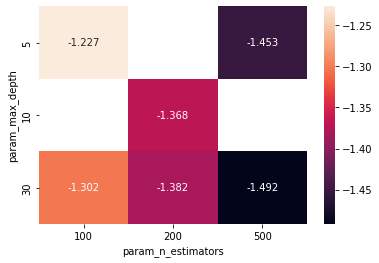

In [ ]:
# plot heatmap to visualise results of hyperparameter tuning
# ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV

max_scores = results.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

#### [Part 2] 8. Compute Performance Metrics with Best Hyperparameters (with class weight)

In [ ]:
def predict_and_plot_perf_matrix_xgb_cw(x_train, y_train, x_test, y_test, clf, class_weights):
    '''
    Perform calibration, make predictions and plot perf matrices
    '''
    clf.fit(x_train, y_train, sample_weight=class_weights)
    cccv = CalibratedClassifierCV(clf, cv='prefit', method="sigmoid")
    cccv.fit(x_train, y_train)
    y_pred = cccv.predict(x_test)
    y_pred_prob = cccv.predict_proba(x_test)
    
    log_loss_clf = log_loss(y_test, y_pred_prob) # log loss takes (y_true, y_pred) where y_pred is prob array for each class
    misclass_prop = np.count_nonzero((y_pred - y_test))/y_test.shape[0]

    print("Log loss: {:.3f}".format(log_loss_clf)) 
    print("% of misclassified points: {:.2%}".format(misclass_prop))
    # print("% of misclassified points: {}".format(round(100*misclass_prop,2))) # same result
    plot_perf_matrix(y_test, y_pred)
    return log_loss_clf, misclass_prop

[16:56:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Log loss: 1.344
% of misclassified points: 35.84%
Precision Matrix (Columm Sum = 1) --------------------------------------------------------------------------------


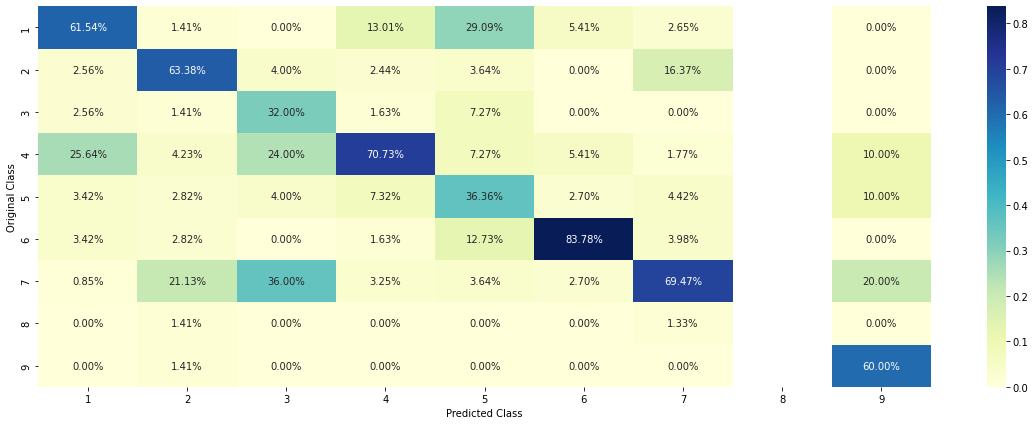

Recall Matrix (Row Sum = 1) --------------------------------------------------------------------------------


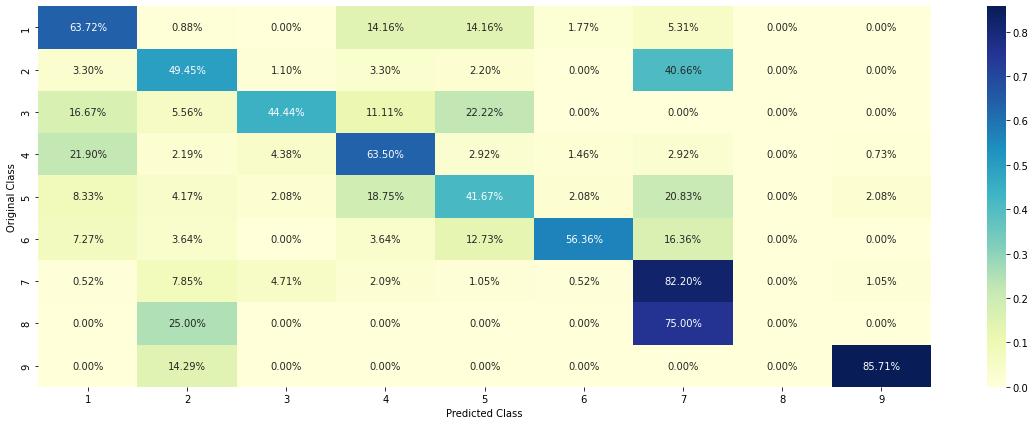

In [ ]:
# best_n_est = clf.best_params_['n_estimators']
# best_depth = clf.best_params_['max_depth']
best_n_est = 100
best_depth = 5
xgb_clf = xgb.XGBClassifier(n_estimators=best_n_est, max_depth=best_depth, random_state=42) # nthread=-1
log_loss_xgb, misclass_prop_xgb = predict_and_plot_perf_matrix_xgb_cw(X_train_tfidf_te, y_train, X_test_tfidf_te, y_test, xgb_clf, class_weights) # class 3,8,9 very few

>* Compared to the previous classifers above so far, the XGBoost classifer has similiar performance across all dimensions.

In [ ]:
get_important_features_te(1, xgb_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 2
Predicted Class Probabilities: [[0.032 0.542 0.004 0.251 0.034 0.029 0.105 0.001 0.002]]
Actual Class : 1
1. Alert: Text feature 5746 [unclassified variants] is important feature, and not present in test data point
2. Alert: Text feature 3151 [lacked] is important feature, and not present in test data point
3. Alert: Text feature 2742 [highly sensitive] is important feature, and not present in test data point
4. Alert: Text feature 2840 [il independent] is important feature, and not present in test data point
5. Alert: Text feature 719 [assay results] is important feature, and not present in test data point
6. Text feature 4199 [phosphoinositide] is important feature, and present in test data point
7. Alert: Text feature 1390 [confer resistance] is important feature, and not present in test data point
8. Text feature 191 [28] is important feature, and present in test data point
9. Alert: Text feature 2828 [idh1] is important feature, and not present in test data poin

In [ ]:
get_important_features_te(2, xgb_clf, X_test_tfidf_te, y_test, X_test, 15)

Predicted Class: 1
Predicted Class Probabilities: [[0.987 0.001 0.    0.012 0.    0.    0.    0.    0.   ]]
Actual Class : 1
1. Alert: Text feature 5746 [unclassified variants] is important feature, and not present in test data point
2. Alert: Text feature 3151 [lacked] is important feature, and not present in test data point
3. Alert: Text feature 2742 [highly sensitive] is important feature, and not present in test data point
4. Alert: Text feature 2840 [il independent] is important feature, and not present in test data point
5. Alert: Text feature 719 [assay results] is important feature, and not present in test data point
6. Alert: Text feature 4199 [phosphoinositide] is important feature, and not present in test data point
7. Alert: Text feature 1390 [confer resistance] is important feature, and not present in test data point
8. Alert: Text feature 191 [28] is important feature, and not present in test data point
9. Alert: Text feature 2828 [idh1] is important feature, and not pre

#### 9. Summary

In [ ]:
!pip install prettytable

In [ ]:
from prettytable import PrettyTable
x1 = PrettyTable()

In [ ]:
best_alpha_nb = 10
best_alpha_sgd = best_alpha_sgd_b = 0.0001
log_loss_nb, log_loss_sgd, log_loss_sgd_b = 1.255, 1.969, 2.140
misclass_prop_nb, misclass_prop_sgd, misclass_prop_sgd_b = 0.43, 0.34, 0.35

best_depth_rf = best_depth_rf_pca = 10
best_depth_rf_b = 30
best_depth_xgb = best_depth_xgb_b = 5

best_n_est_rf = best_n_est_rf_pca = 200
best_n_est_rf_b = 500
best_n_est_xgb = best_n_est_xgb_b = 100
log_loss_rf, log_loss_rf_b, log_loss_rf_pca, log_loss_xgb, log_loss_xgb_b = 1.078, 1.234, 1.110, 1.346, 1.344
misclass_prop_rf, misclass_prop_rf_b, misclass_prop_rf_pca, misclass_prop_xgb, misclass_prop_xgb_b = 0.35, 0.36, 0.36, 0.34, 0.36

In [ ]:
x1.field_names = ["Text Vec.", "Cat. Encoding", "Model", "Class Weightage", "Hyperparameter: alpha", 
                 "Log Loss", "% Misclass."]
x1.add_rows(
    [
        ["TFIDF", "One Hot Encoded", "Multinomial Naive Bayes", "n/a", best_alpha_nb, log_loss_nb, misclass_prop_nb],
        ["TFIDF", "One Hot Encoded", "Logistic Regression", "n/a", best_alpha_sgd, log_loss_sgd, misclass_prop_sgd],
        ["TFIDF", "One Hot Encoded", "Logistic Regression", "Balanced", best_alpha_sgd_b, log_loss_sgd_b, misclass_prop_sgd_b]
    ]
)
print(x1)

+-----------+-----------------+-------------------------+-----------------+-----------------------+----------+-------------+
| Text Vec. |  Cat. Encoding  |          Model          | Class Weightage | Hyperparameter: alpha | Log Loss | % Misclass. |
+-----------+-----------------+-------------------------+-----------------+-----------------------+----------+-------------+
|   TFIDF   | One Hot Encoded | Multinomial Naive Bayes |       n/a       |           10          |  1.255   |     0.43    |
|   TFIDF   | One Hot Encoded |   Logistic Regression   |       n/a       |         0.0001        |  1.969   |     0.34    |
|   TFIDF   | One Hot Encoded |   Logistic Regression   |     Balanced    |         0.0001        |   2.14   |     0.35    |
+-----------+-----------------+-------------------------+-----------------+-----------------------+----------+-------------+


In [ ]:
x2 = PrettyTable()

x2.field_names = ["Text Vec.", "Cat. Encoding", "Model", "Class Weightage", "max_depth", 
                  "n_estimators", "Log Loss", "% Misclass."]
x2.add_rows(
    [
        ["TFIDF", "Response Encoded", "Random Forest", "n/a", best_depth_rf, best_n_est_rf, log_loss_rf, misclass_prop_rf],
        ["TFIDF", "Response Encoded", "Random Forest", "Balanced", best_depth_rf_b, best_n_est_rf_b, log_loss_rf_b, misclass_prop_rf_b],
        ["TFIDF", "Response Encoded-PCA", "Random Forest", "n/a", best_depth_rf_pca, best_n_est_rf_pca, log_loss_rf_pca, misclass_prop_rf_pca],
        ["TFIDF", "Response Encoded", "XGBoost", "n/a", best_depth_xgb, best_n_est_xgb, log_loss_xgb, misclass_prop_xgb],
        ["TFIDF", "Response Encoded", "XGBoost", "Balanced", best_depth_xgb_b, best_n_est_xgb_b, log_loss_xgb_b, misclass_prop_xgb_b]
    ]
)
print(x2)

+-----------+----------------------+---------------+-----------------+-----------+--------------+----------+-------------+
| Text Vec. |    Cat. Encoding     |     Model     | Class Weightage | max_depth | n_estimators | Log Loss | % Misclass. |
+-----------+----------------------+---------------+-----------------+-----------+--------------+----------+-------------+
|   TFIDF   |   Response Encoded   | Random Forest |       n/a       |     10    |     200      |  1.078   |     0.35    |
|   TFIDF   |   Response Encoded   | Random Forest |     Balanced    |     30    |     500      |  1.234   |     0.36    |
|   TFIDF   | Response Encoded-PCA | Random Forest |       n/a       |     10    |     200      |   1.11   |     0.36    |
|   TFIDF   |   Response Encoded   |    XGBoost    |       n/a       |     5     |     100      |  1.346   |     0.34    |
|   TFIDF   |   Response Encoded   |    XGBoost    |     Balanced    |     5     |     100      |  1.344   |     0.36    |
+-----------+---

>* The different classifiers tried in this exercise returned similiar precision, recall, log loss and overall proportion of correctly classified points. Logistic regression stands out with better performance for rare classes (in particular class 8), but has worse log loss.
>* As the performance across all the different algorithms do not differ by much, this suggests that better feature engineering, more precise hyperparameter tuning and improved handling of imbalanced class distribution is needed to improve model performance. Feature engineering is probably the most important as the classes do not appear to be very easily separable as seen from t-SNE.